In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import xgboost
warnings.filterwarnings('ignore')

import category_encoders as ce

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import RobustScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

C:\Users\ryana\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('data_bank_marketing_campaign.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [4]:
df.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


## Check Column 

- Age: Age Customer 
- Job: type Job Customer
- Balance: balance in bank 
- Housing: Is Customer have house (Yes / No)
- Loan: Is Customer have loan (Yes / No)
- contact:  contact communication type
- month: last contact month of year
- campaign: number of contacts performed during this campaign and for this client
- pdays: preparation days; number of days that passed by after the client was last contacted from a previous campaign
- poutcome: outcome of the previous marketing campaign
- deposit: Is Customer want deposit (Yes / No)

- source: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [5]:
## Check Missing Value 

In [6]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

In [7]:
bankDesc = []
for i in df.columns:
    bankDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round(((df[i].isna().sum() / len(df)) * 100), 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])
pd.DataFrame(
data=bankDesc,
columns = [
    'Features',
    'DataType',
    'Null',
    'NullPercentage',
    'Unique',
    'Unique Sample'
])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,age,int64,0,0.0,75,"[58, 20]"
1,job,object,0,0.0,12,"[admin., unknown]"
2,balance,int64,0,0.0,3153,"[392, 1540]"
3,housing,object,0,0.0,2,"[no, yes]"
4,loan,object,0,0.0,2,"[yes, no]"
5,contact,object,0,0.0,3,"[telephone, unknown]"
6,month,object,0,0.0,12,"[mar, sep]"
7,campaign,int64,0,0.0,32,"[2, 22]"
8,pdays,int64,0,0.0,422,"[532, 289]"
9,poutcome,object,0,0.0,4,"[failure, unknown]"


In [8]:
## Check Outlier 

In [9]:
Q1 = df.describe()['balance']['25%']
Q3 = df.describe()['balance']['75%']

In [10]:
IQR = Q3 - Q1 

In [11]:
lower_balance = Q1 - (1.5 * IQR)
upper_balance = Q3 + (1.5 * IQR)

In [12]:
outlier_balance = df[(df['balance'] < lower_balance) | (df['balance'] > upper_balance)]
outlier_balance

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
6,37,admin.,4803,no,no,cellular,jan,2,-1,unknown,yes
14,30,management,4808,no,no,cellular,mar,1,-1,unknown,yes
21,57,management,4929,yes,no,telephone,jul,4,-1,unknown,no
36,47,management,6651,no,no,cellular,jul,1,412,failure,yes
...,...,...,...,...,...,...,...,...,...,...,...
7799,30,management,5381,no,no,cellular,nov,1,-1,unknown,no
7801,50,blue-collar,4108,yes,no,cellular,aug,2,-1,unknown,yes
7802,63,retired,12067,no,no,telephone,apr,1,191,failure,yes
7806,53,management,13901,yes,no,cellular,nov,1,-1,unknown,no


## Make categorize according generation

In [13]:
def category(age):
    
    if age <= 24:
        x = 'Z'
    elif age >= 25 and age <= 40:
        x = 'Millenial'
    elif age >= 41 and age <= 56:
        x = 'X'
    else:
        x = 'Baby Boomer'
        
    return x

In [14]:
df['generation'] = df['age'].apply(lambda x: category(x))

In [15]:
df.sample(5)

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,generation
5130,58,admin.,247,no,yes,unknown,jun,6,-1,unknown,no,Baby Boomer
6524,46,services,2948,no,no,cellular,nov,1,-1,unknown,yes,X
4506,28,blue-collar,173,no,no,cellular,jul,7,-1,unknown,yes,Millenial
7134,36,admin.,4708,no,no,cellular,jun,1,-1,unknown,no,Millenial
1610,46,blue-collar,138,no,no,cellular,nov,1,-1,unknown,no,X


## Exploratory Data Analysis

In [16]:
df_loan = (pd.crosstab(index=df['generation'], columns=df['loan'], values=df['loan'], aggfunc='count', normalize='index') * 100).round(2).reset_index()
df_loan

loan,generation,no,yes
0,Baby Boomer,92.67,7.33
1,Millenial,87.17,12.83
2,X,83.87,16.13
3,Z,92.89,7.11


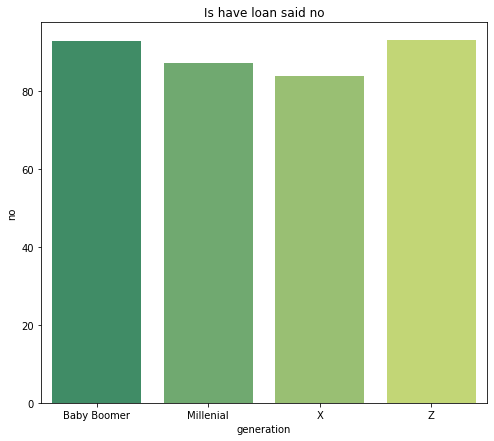

In [17]:
plt.figure(figsize=(8,7))
sns.barplot(df_loan['generation'], df_loan['no'], palette='summer')
plt.title("Is have loan said no")
plt.savefig("loan no.png")

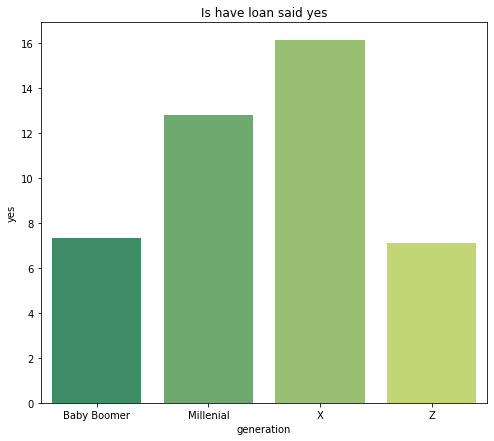

In [18]:
plt.figure(figsize=(8,7))
sns.barplot(df_loan['generation'], df_loan['yes'], palette='summer')
plt.title("Is have loan said yes")
plt.savefig("loan yes.png")

In [19]:
df_month = pd.crosstab(index=df['month'], columns='transaction', values='transaction', aggfunc='count').reset_index()
df_month1 = df_month.iloc[[4,3,7,0,8,6,5,1,11,10,9,2]]
df_month1

col_0,month,transaction
4,jan,227
3,feb,534
7,mar,199
0,apr,662
8,may,1976
6,jun,857
5,jul,1050
1,aug,1085
11,sep,212
10,oct,286


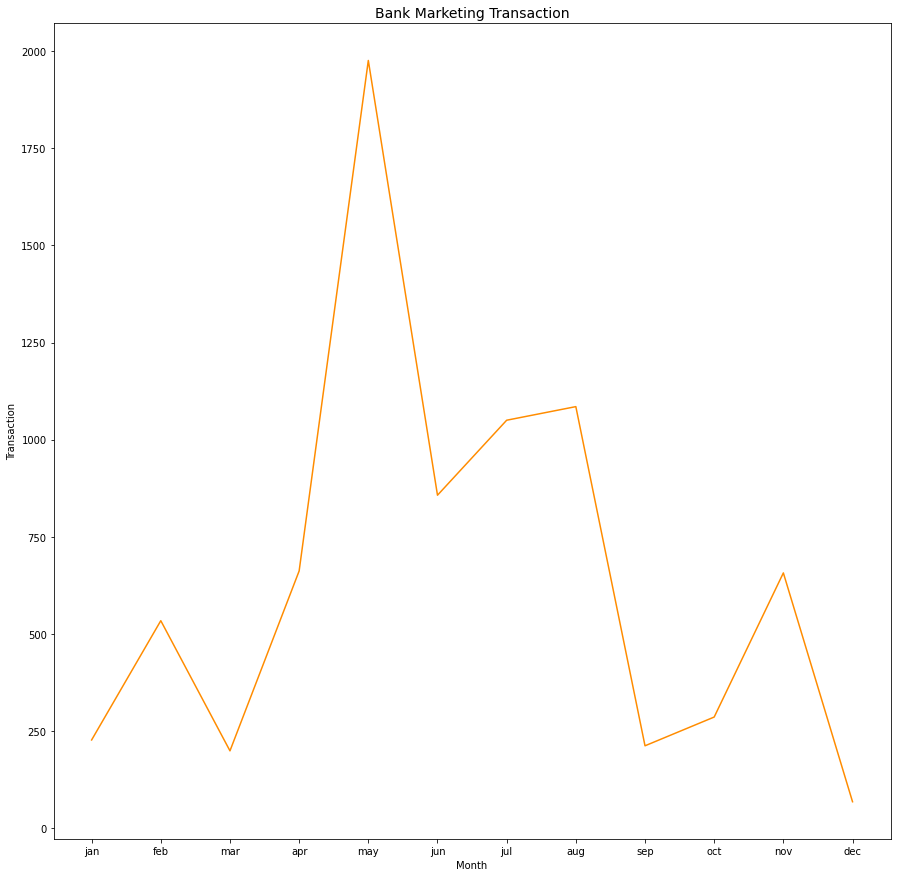

In [20]:
plt.figure(figsize=(15,15))
plt.plot(df_month1['month'], df_month1['transaction'], color='darkorange')
plt.xlabel("Month")
plt.ylabel("Transaction")
plt.title("Bank Marketing Transaction", fontsize=14)
plt.savefig("Bank Marketing.png")

## Machine Learning 

In [21]:
df1 = df.copy()

In [22]:
df1 = df1.drop(columns=['generation'], axis=1)

In [23]:
df1.head()

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no


In [24]:
df1['housing'] = df1['housing'].map({'yes' : 1, 'no' : 0})
df1['loan'] = df1['loan'].map({'yes' : 1, 'no' : 0})
df1['deposit'] = df1['deposit'].map({'yes' : 1, 'no' : 0})

In [25]:
df1['poutcome'].value_counts()

unknown    5819
failure     848
success     761
other       385
Name: poutcome, dtype: int64

In [26]:
binary_month = ce.BinaryEncoder(cols=['month'])
binary_job = ce.BinaryEncoder(cols=['job'])

In [27]:
df_binary_month = binary_month.fit_transform(df1['month'])
df_binary_job = binary_job.fit_transform(df1['job'])

In [28]:
df2 = pd.concat([df1, df_binary_month, df_binary_job], axis=1)

In [29]:
df2 = df2.drop(columns=['job','month'])

In [30]:
df2 = pd.get_dummies(df2, columns=['contact','poutcome'])

## Check Imbalance Data for target

In [31]:
df2['deposit'].value_counts() / len(df2) * 100

0    52.233457
1    47.766543
Name: deposit, dtype: float64

### This target is balance, thus can be get target for ML Process

In [32]:
X = df2.drop(columns=['deposit'])
y = df2['deposit']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=.80, random_state=42)

In [34]:
X_train.head()

,age,balance,housing,loan,campaign,pdays,month_0,month_1,month_2,month_3,...,job_1,job_2,job_3,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
1459,56,563,1,0,2,168,0,0,1,1,...,1,1,0,1,0,0,1,0,0,0
3231,32,390,1,0,1,-1,0,0,1,1,...,1,0,1,0,0,1,0,0,0,1
2502,30,69,1,0,1,-1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,1
4107,31,-205,0,0,1,579,0,1,1,0,...,0,1,1,1,0,0,1,0,0,0
3994,34,-312,1,0,1,-1,0,0,1,1,...,0,0,1,0,0,1,0,0,0,1


In [35]:
X_test.head()

,age,balance,housing,loan,campaign,pdays,month_0,month_1,month_2,month_3,...,job_1,job_2,job_3,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
2266,32,-383,1,0,1,-1,0,0,1,1,...,1,1,0,0,0,1,0,0,0,1
7393,37,608,0,0,3,-1,0,0,1,1,...,0,1,1,1,0,0,0,0,0,1
1541,31,-422,1,0,2,329,0,0,1,1,...,0,0,1,1,0,0,0,1,0,0
1426,30,128,1,0,1,-1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
2454,56,7747,0,0,2,-1,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1


In [36]:
def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    Acc = accuracy_score(y_true, y_pred)
    Rec = recall_score(y_true, y_pred)
    Prec = precision_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    return Acc, Rec, Prec, F1

## Logistic Regression

In [37]:
model_LR = LogisticRegression()

In [38]:
model_LR.fit(X_train, y_train)

LogisticRegression()

In [39]:
y_pred_train = model_LR.predict(X_train)

In [40]:
Log_Acc_train, Log_Rec_train, Log_Prec_train, Log_F1_train = Eva_Matrix(model_LR, X_train, y_train)

In [41]:
Log_Acc_test, Log_Rec_test, Log_Prec_test, Log_F1_test = Eva_Matrix(model_LR, X_test, y_test)

In [42]:
data_log = {
    "Log Train" : [Log_Acc_train, Log_Rec_train, Log_Prec_train, Log_F1_train],
    "Log Test" : [Log_Acc_test, Log_Rec_test, Log_Prec_test, Log_F1_test]
}

In [43]:
LOG1 = pd.DataFrame(data=data_log, index = ['Accuracy','Recall','Precision','F1'])
LOG1

,Log Train,Log Test
Accuracy,0.669920,0.674344
Recall,0.644556,0.659973
Precision,0.657553,0.659091
F1,0.650990,0.659532


In [44]:
y_train_LR = model_LR.predict(X_train)

In [45]:
print(classification_report(y_train_LR, y_train))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      3324
           1       0.64      0.66      0.65      2926

    accuracy                           0.67      6250
   macro avg       0.67      0.67      0.67      6250
weighted avg       0.67      0.67      0.67      6250



In [46]:
cm_train_LR = confusion_matrix(y_train_LR, y_train, labels=[1, 0])

In [47]:
df_cm_LR = pd.DataFrame(data=cm_train_LR, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_LR

,Pred 1,Pred 0
Akt 1,1924,1002
Akt 0,1061,2263


<AxesSubplot:>

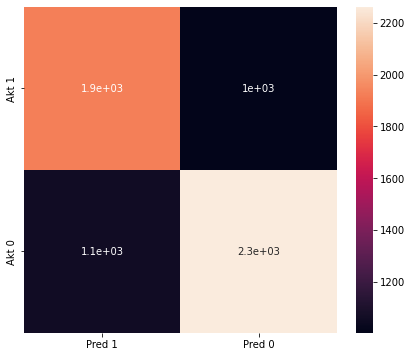

In [48]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_LR,annot=True)

In [49]:
y_test_LR = model_LR.predict(X_test)

In [50]:
print(classification_report(y_test_LR, y_test))

              precision    recall  f1-score   support

           0       0.69      0.69      0.69       815
           1       0.66      0.66      0.66       748

    accuracy                           0.67      1563
   macro avg       0.67      0.67      0.67      1563
weighted avg       0.67      0.67      0.67      1563



In [51]:
cm_test_LR = confusion_matrix(y_test_LR, y_test, labels=[1, 0])

In [52]:
df_cm_test_LR = pd.DataFrame(data=cm_test_LR, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_LR

,Pred 1,Pred 0
Akt 1,493,255
Akt 0,254,561


<AxesSubplot:>

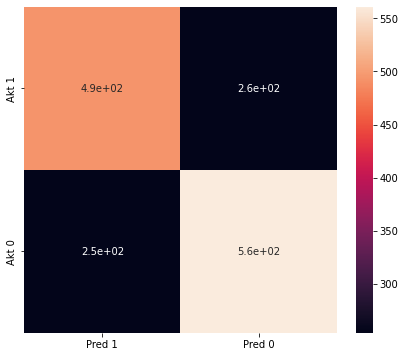

In [53]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_LR,annot=True)

## KNN

In [54]:
KNN = KNeighborsClassifier()

In [55]:
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [56]:
y_pred_train_KNN = KNN.predict(X_train)

In [57]:
KNN_Acc_train, KNN_Rec_train, KNN_Prec_train, KNN_F1_train = Eva_Matrix(KNN, X_train, y_train)

In [58]:
KNN_Acc_test, KNN_Rec_test, KNN_Prec_test, KNN_F1_test = Eva_Matrix(KNN, X_test, y_test)

In [59]:
data_knn = {
    "KNN Train" : [KNN_Acc_train, KNN_Rec_train, KNN_Prec_train, KNN_F1_train],
    "KNN Test" : [KNN_Acc_test, KNN_Rec_test, KNN_Prec_test, KNN_F1_test]
}

In [60]:
KNN1 = pd.DataFrame(data=data_knn, index = ['Accuracy','Recall','Precision','F1'])
KNN1

,KNN Train,KNN Test
Accuracy,0.730560,0.606526
Recall,0.675377,0.552878
Precision,0.738191,0.595101
F1,0.705388,0.573213


In [61]:
y_train_KNN = KNN.predict(X_train)

In [62]:
print(classification_report(y_train_KNN, y_train))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3519
           1       0.68      0.74      0.71      2731

    accuracy                           0.73      6250
   macro avg       0.73      0.73      0.73      6250
weighted avg       0.73      0.73      0.73      6250



In [63]:
cm_train_KNN = confusion_matrix(y_train_KNN, y_train, labels=[1, 0])

In [64]:
df_cm_train_KNN = pd.DataFrame(data=cm_train_KNN, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_KNN

,Pred 1,Pred 0
Akt 1,2016,715
Akt 0,969,2550


<AxesSubplot:>

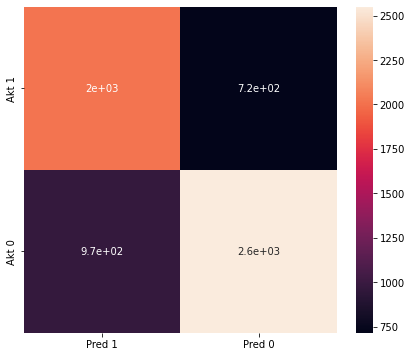

In [65]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_KNN,annot=True)

In [66]:
y_test_KNN = KNN.predict(X_test)

In [67]:
print(classification_report(y_test_KNN, y_test))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       869
           1       0.55      0.60      0.57       694

    accuracy                           0.61      1563
   macro avg       0.60      0.61      0.60      1563
weighted avg       0.61      0.61      0.61      1563



In [68]:
cm_test_KNN = confusion_matrix(y_test_KNN, y_test, labels=[1, 0])

In [69]:
df_cm_test_KNN = pd.DataFrame(data=cm_test_KNN, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_KNN

,Pred 1,Pred 0
Akt 1,413,281
Akt 0,334,535


<AxesSubplot:>

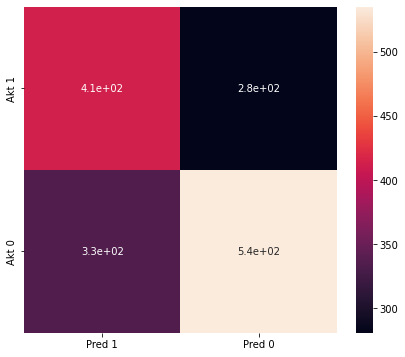

In [70]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_KNN,annot=True)

## SVM

In [71]:
SVM = SVC()

In [72]:
SVM.fit(X_train, y_train)

SVC()

In [73]:
y_pred_train_SVM = SVM.predict(X_train)

In [74]:
SVM_Acc_train, SVM_Rec_train, SVM_Prec_train, SVM_F1_train = Eva_Matrix(SVM, X_train, y_train)

In [75]:
SVM_Acc_test, SVM_Rec_test, SVM_Prec_test, SVM_F1_test = Eva_Matrix(SVM, X_test, y_test)

In [76]:
data_svm = {
    "SVM Train" : [SVM_Acc_train, SVM_Rec_train, SVM_Prec_train, SVM_F1_train],
    "SVM Test" : [SVM_Acc_test, SVM_Rec_test, SVM_Prec_test, SVM_F1_test]
}

In [77]:
SVM1 = pd.DataFrame(data=data_svm, index = ['Accuracy','Recall','Precision','F1'])
SVM1

,SVM Train,SVM Test
Accuracy,0.566560,0.607806
Recall,0.385595,0.427041
Precision,0.568115,0.632937
F1,0.459389,0.509992


In [78]:
y_train_SVM = SVM.predict(X_train)

In [79]:
print(classification_report(y_train_SVM, y_train))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      4224
           1       0.39      0.57      0.46      2026

    accuracy                           0.57      6250
   macro avg       0.56      0.57      0.55      6250
weighted avg       0.62      0.57      0.58      6250



In [80]:
cm_train_SVM = confusion_matrix(y_train_SVM, y_train, labels=[1, 0])

In [81]:
df_cm_train_SVM = pd.DataFrame(data=cm_train_SVM, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_SVM

,Pred 1,Pred 0
Akt 1,1151,875
Akt 0,1834,2390


<AxesSubplot:>

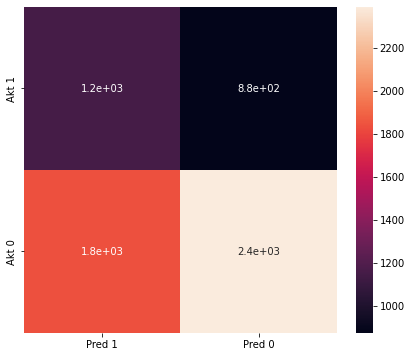

In [82]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_SVM,annot=True)

## Decision Tree

In [83]:
DT = DecisionTreeClassifier()

In [84]:
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [85]:
y_pred_train_DT = DT.predict(X_train)

In [86]:
DT_Acc_train, DT_Rec_train, DT_Prec_train, DT_F1_train = Eva_Matrix(DT, X_train, y_train)

In [87]:
DT_Acc_test, DT_Rec_test, DT_Prec_test, DT_F1_test = Eva_Matrix(DT, X_test, y_test)

In [88]:
data_dt = {
    "Decision Tree Train" : [DT_Acc_train, DT_Rec_train, DT_Prec_train, DT_F1_train],
    "Decision Tree Test" : [DT_Acc_test, DT_Rec_test, DT_Prec_test, DT_F1_test]
}

In [89]:
DT1 = pd.DataFrame(data=data_dt, index = ['Accuracy','Recall','Precision','F1'])
DT1 

,Decision Tree Train,Decision Tree Test
Accuracy,0.999680,0.618042
Recall,0.999330,0.603748
Precision,1.000000,0.599734
F1,0.999665,0.601734


In [90]:
y_train_DT = DT.predict(X_train)

In [91]:
print(classification_report(y_train_DT, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3267
           1       1.00      1.00      1.00      2983

    accuracy                           1.00      6250
   macro avg       1.00      1.00      1.00      6250
weighted avg       1.00      1.00      1.00      6250



In [92]:
cm_train_DT = confusion_matrix(y_train_DT, y_train, labels=[1, 0])

In [93]:
df_cm_train_DT = pd.DataFrame(data=cm_train_DT, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_DT

,Pred 1,Pred 0
Akt 1,2983,0
Akt 0,2,3265


<AxesSubplot:>

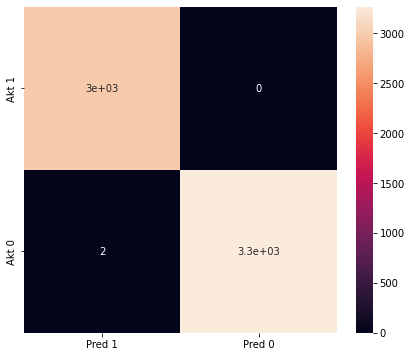

In [94]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_DT,annot=True)

In [95]:
y_test_DT = DT.predict(X_test)

In [96]:
print(classification_report(y_test_DT, y_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       811
           1       0.60      0.60      0.60       752

    accuracy                           0.62      1563
   macro avg       0.62      0.62      0.62      1563
weighted avg       0.62      0.62      0.62      1563



In [97]:
cm_test_DT = confusion_matrix(y_test_DT, y_test, labels=[1, 0])

In [98]:
df_cm_test_DT = pd.DataFrame(data=cm_test_DT, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_DT

,Pred 1,Pred 0
Akt 1,451,301
Akt 0,296,515


<AxesSubplot:>

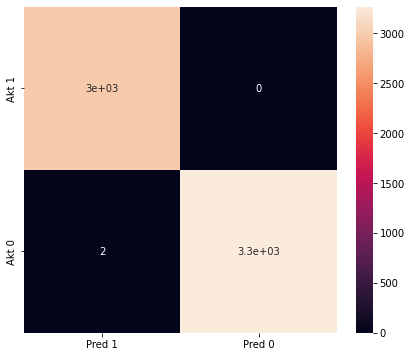

In [99]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_DT,annot=True)

## Random Forest

In [100]:
RF = RandomForestClassifier()

In [101]:
RF.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred_train_RF = RF.predict(X_train)

In [103]:
RF_Acc_train, RF_Rec_train, RF_Prec_train, RF_F1_train = Eva_Matrix(RF, X_train, y_train)

In [104]:
RF_Acc_test, RF_Rec_test, RF_Prec_test, RF_F1_test = Eva_Matrix(RF, X_test, y_test)

In [105]:
data_rf = {
    "Random Forest Train" : [RF_Acc_train, RF_Rec_train, RF_Prec_train, RF_F1_train],
    "Random Forest Test" : [RF_Acc_test, RF_Rec_test, RF_Prec_test, RF_F1_test]
}

In [106]:
RF1 = pd.DataFrame(data=data_rf, index = ['Accuracy','Recall','Precision','F1'])
RF1

,Random Forest Train,Random Forest Test
Accuracy,0.999520,0.694818
Recall,0.999330,0.631861
Precision,0.999665,0.700297
F1,0.999497,0.664321


In [107]:
y_train_RF = RF.predict(X_train)

In [108]:
print(classification_report(y_train_RF, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3266
           1       1.00      1.00      1.00      2984

    accuracy                           1.00      6250
   macro avg       1.00      1.00      1.00      6250
weighted avg       1.00      1.00      1.00      6250



In [109]:
cm_train_RF = confusion_matrix(y_train_RF, y_train, labels=[1, 0])

In [110]:
df_cm_train_RF = pd.DataFrame(data=cm_train_RF, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_RF

,Pred 1,Pred 0
Akt 1,2983,1
Akt 0,2,3264


<AxesSubplot:>

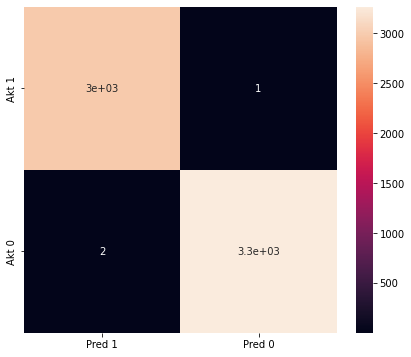

In [111]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_RF,annot=True)

In [112]:
y_test_RF = RF.predict(X_test)

In [113]:
print(classification_report(y_test_RF, y_test))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       889
           1       0.63      0.70      0.66       674

    accuracy                           0.69      1563
   macro avg       0.69      0.70      0.69      1563
weighted avg       0.70      0.69      0.70      1563



In [114]:
cm_test_RF = confusion_matrix(y_test_RF, y_test, labels=[1, 0])

In [115]:
df_cm_test_RF = pd.DataFrame(data=cm_test_RF, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_RF

,Pred 1,Pred 0
Akt 1,472,202
Akt 0,275,614


<AxesSubplot:>

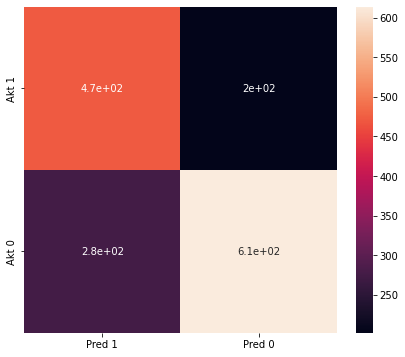

In [116]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_RF,annot=True)

## XGB

In [117]:
XGB = XGBClassifier()

In [118]:
XGB.fit(X_train, y_train)

[19:42:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [119]:
y_pred_train_XGB = XGB.predict(X_train)

In [120]:
XGB_Acc_train, XGB_Rec_train, XGB_Prec_train, XGB_F1_train = Eva_Matrix(XGB, X_train, y_train)

In [121]:
XGB_Acc_test, XGB_Rec_test, XGB_Prec_test, XGB_F1_test = Eva_Matrix(XGB, X_test, y_test)

In [122]:
data_xgb = {
    "XGB Train" : [XGB_Acc_train, XGB_Rec_train, XGB_Prec_train, XGB_F1_train],
    "XGB Test" : [XGB_Acc_test, XGB_Rec_test, XGB_Prec_test, XGB_F1_test]
}

In [123]:
XGB1 = pd.DataFrame(data=data_xgb, index = ['Accuracy','Recall','Precision','F1'])
XGB1

,XGB Train,XGB Test
Accuracy,0.881440,0.692898
Recall,0.821106,0.619813
Precision,0.922122,0.702580
F1,0.868687,0.658606


In [124]:
y_train_XGB = XGB.predict(X_train)

In [125]:
print(classification_report(y_train_XGB, y_train))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3592
           1       0.82      0.92      0.87      2658

    accuracy                           0.88      6250
   macro avg       0.88      0.89      0.88      6250
weighted avg       0.89      0.88      0.88      6250



In [126]:
cm_train_XGB = confusion_matrix(y_train_XGB, y_train, labels=[1, 0])

In [127]:
df_cm_train_XGB = pd.DataFrame(data=cm_train_XGB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_XGB

,Pred 1,Pred 0
Akt 1,2451,207
Akt 0,534,3058


<AxesSubplot:>

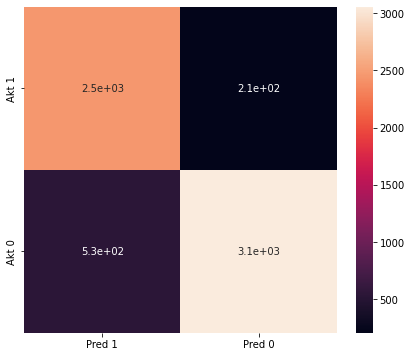

In [128]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_XGB,annot=True)

In [129]:
y_test_XGB = XGB.predict(X_test)

In [130]:
print(classification_report(y_test_XGB, y_test))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       904
           1       0.62      0.70      0.66       659

    accuracy                           0.69      1563
   macro avg       0.69      0.69      0.69      1563
weighted avg       0.70      0.69      0.69      1563



In [131]:
cm_test_XGB = confusion_matrix(y_test_XGB, y_test, labels=[1, 0])

In [132]:
df_cm_test_XGB = pd.DataFrame(data=cm_test_XGB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_XGB

,Pred 1,Pred 0
Akt 1,463,196
Akt 0,284,620


<AxesSubplot:>

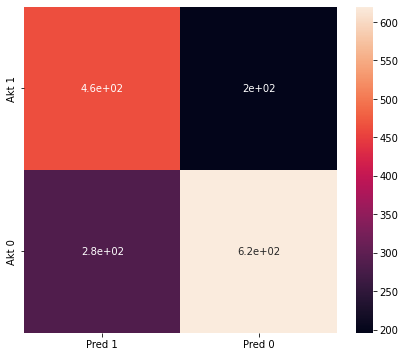

In [133]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_XGB,annot=True)

## Ada Boost

In [134]:
AB = AdaBoostClassifier()

In [135]:
AB.fit(X_train, y_train)

AdaBoostClassifier()

In [136]:
y_pred_train_AB = AB.predict(X_train)

In [137]:
AB_Acc_train, AB_Rec_train, AB_Prec_train, AB_F1_train = Eva_Matrix(AB, X_train, y_train)

In [138]:
AB_Acc_test, AB_Rec_test, AB_Prec_test, AB_F1_test = Eva_Matrix(AB, X_test, y_test)

In [139]:
data_ab = {
    "Ada Boost Train" : [AB_Acc_train, AB_Rec_train, AB_Prec_train, AB_F1_train],
    "Ada Boost Test" : [AB_Acc_test, AB_Rec_test, AB_Prec_test, AB_F1_test]
}

In [140]:
AB1 = pd.DataFrame(data=data_ab, index = ['Accuracy','Recall','Precision','F1'])
AB1

,Ada Boost Train,Ada Boost Test
Accuracy,0.701280,0.697377
Recall,0.624456,0.621151
Precision,0.714176,0.709480
F1,0.666309,0.662384


In [141]:
y_train_AB = AB.predict(X_train)

In [142]:
print(classification_report(y_train_AB, y_train))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      3640
           1       0.62      0.71      0.67      2610

    accuracy                           0.70      6250
   macro avg       0.70      0.70      0.70      6250
weighted avg       0.71      0.70      0.70      6250



In [143]:
cm_train_AB = confusion_matrix(y_train_AB, y_train, labels=[1, 0])

In [144]:
df_cm_train_AB = pd.DataFrame(data=cm_train_AB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_AB

,Pred 1,Pred 0
Akt 1,1864,746
Akt 0,1121,2519


<AxesSubplot:>

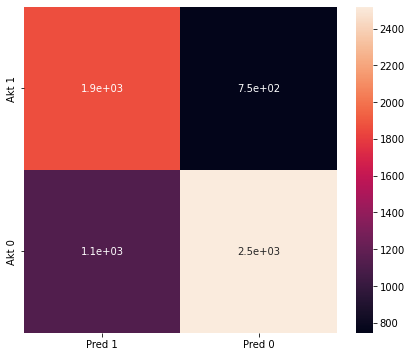

In [145]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_AB,annot=True)

In [146]:
y_test_AB = AB.predict(X_test)

In [147]:
print(classification_report(y_test_AB, y_test))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       909
           1       0.62      0.71      0.66       654

    accuracy                           0.70      1563
   macro avg       0.69      0.70      0.69      1563
weighted avg       0.71      0.70      0.70      1563



In [148]:
cm_test_AB = confusion_matrix(y_test_AB, y_test, labels=[1, 0])

In [149]:
df_cm_test_AB = pd.DataFrame(data=cm_test_AB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_AB

,Pred 1,Pred 0
Akt 1,464,190
Akt 0,283,626


<AxesSubplot:>

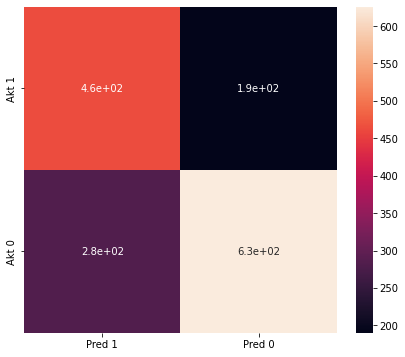

In [150]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_AB,annot=True)

## Gradient Boost

In [151]:
GB = GradientBoostingClassifier()

In [152]:
GB.fit(X_train, y_train)

GradientBoostingClassifier()

In [153]:
GB_Acc_train, GB_Rec_train, GB_Prec_train, GB_F1_train = Eva_Matrix(GB, X_train, y_train)

In [154]:
GB_Acc_test, GB_Rec_test, GB_Prec_test, GB_F1_test = Eva_Matrix(GB, X_test, y_test)

In [155]:
data_gb = {
    "Gradient Boost Train" : [GB_Acc_train, GB_Rec_train, GB_Prec_train, GB_F1_train],
    "Gradient Boost Test" : [GB_Acc_test, GB_Rec_test, GB_Prec_test, GB_F1_test]
}

In [156]:
GB1 = pd.DataFrame(data=data_gb, index = ['Accuracy','Recall','Precision','F1'])
GB1

,Gradient Boost Train,Gradient Boost Test
Accuracy,0.728640,0.726168
Recall,0.633166,0.627845
Precision,0.758731,0.757674
F1,0.690285,0.686676


In [157]:
y_train_GB = GB.predict(X_train)

In [158]:
print(classification_report(y_train_GB, y_train))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      3759
           1       0.63      0.76      0.69      2491

    accuracy                           0.73      6250
   macro avg       0.72      0.73      0.72      6250
weighted avg       0.74      0.73      0.73      6250



In [159]:
cm_train_GB = confusion_matrix(y_train_GB, y_train, labels=[1, 0])

In [160]:
df_cm_train_GB = pd.DataFrame(data=cm_train_GB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_GB

,Pred 1,Pred 0
Akt 1,1890,601
Akt 0,1095,2664


<AxesSubplot:>

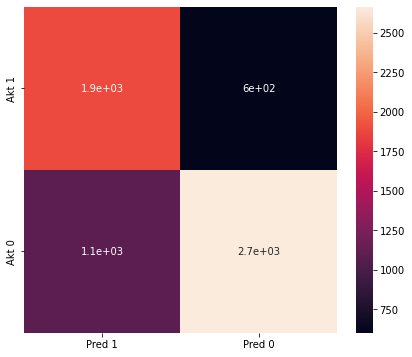

In [161]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_GB,annot=True)

In [162]:
y_test_GB = GB.predict(X_test)

In [163]:
print(classification_report(y_test_GB, y_test))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       944
           1       0.63      0.76      0.69       619

    accuracy                           0.73      1563
   macro avg       0.72      0.73      0.72      1563
weighted avg       0.74      0.73      0.73      1563



In [164]:
cm_test_GB = confusion_matrix(y_test_GB, y_test, labels=[1, 0])

In [165]:
df_cm_test_GB = pd.DataFrame(data=cm_test_GB, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_GB

,Pred 1,Pred 0
Akt 1,469,150
Akt 0,278,666


<AxesSubplot:>

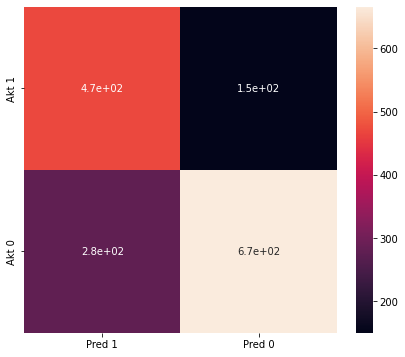

In [166]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_GB,annot=True)

## Naive Bayes

In [167]:
gnb = GaussianNB()

In [168]:
gnb.fit(X_train, y_train)

GaussianNB()

In [169]:
gnb_Acc_train, gnb_Rec_train, gnb_Prec_train, gnb_F1_train = Eva_Matrix(gnb, X_train, y_train)

In [170]:
gnb_Acc_test, gnb_Rec_test, gnb_Prec_test, gnb_F1_test = Eva_Matrix(gnb, X_test, y_test)

In [171]:
data_gnb = {
    "Naive Bayes Train" : [gnb_Acc_train, gnb_Rec_train, gnb_Prec_train, gnb_F1_train],
    "Naive Bayes Test" : [gnb_Acc_test, gnb_Rec_test, gnb_Prec_test, gnb_F1_test]
}

In [172]:
GNB1 = pd.DataFrame(data=data_gnb, index = ['Accuracy','Recall','Precision','F1'])
GNB1

,Naive Bayes Train,Naive Bayes Test
Accuracy,0.648640,0.678183
Recall,0.568509,0.589023
Precision,0.651440,0.691824
F1,0.607156,0.636298


In [173]:
y_train_gnb = gnb.predict(X_train)

In [174]:
print(classification_report(y_train_gnb, y_train))

              precision    recall  f1-score   support

           0       0.72      0.65      0.68      3645
           1       0.57      0.65      0.61      2605

    accuracy                           0.65      6250
   macro avg       0.65      0.65      0.64      6250
weighted avg       0.66      0.65      0.65      6250



In [175]:
cm_train_gnb = confusion_matrix(y_train_gnb, y_train, labels=[1, 0])

In [176]:
df_cm_train_gnb = pd.DataFrame(data=cm_train_gnb, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_gnb

,Pred 1,Pred 0
Akt 1,1697,908
Akt 0,1288,2357


<AxesSubplot:>

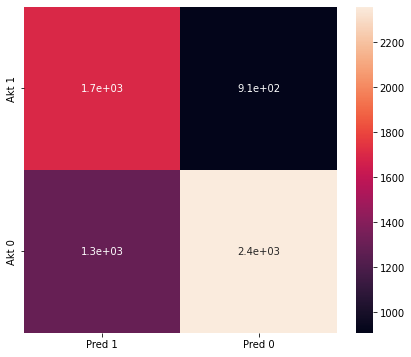

In [177]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_gnb,annot=True)

In [178]:
y_test_gnb = gnb.predict(X_test)

In [179]:
print(classification_report(y_test_gnb, y_test))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71       927
           1       0.59      0.69      0.64       636

    accuracy                           0.68      1563
   macro avg       0.67      0.68      0.67      1563
weighted avg       0.69      0.68      0.68      1563



In [180]:
cm_test_gnb = confusion_matrix(y_test_gnb, y_test, labels=[1, 0])

In [181]:
df_cm_test_gnb = pd.DataFrame(data=cm_test_gnb, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_gnb

,Pred 1,Pred 0
Akt 1,440,196
Akt 0,307,620


<AxesSubplot:>

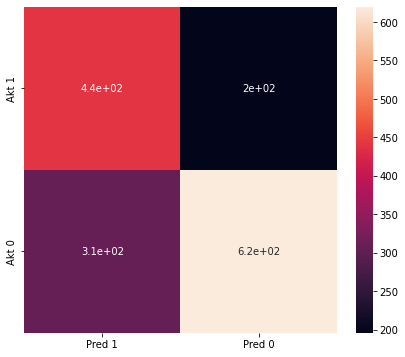

In [182]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_gnb,annot=True)

## Cat Boost

In [183]:
cb = CatBoostClassifier()

In [184]:
cb.fit(X_train, y_train)

Learning rate set to 0.022531
0:	learn: 0.6885552	total: 173ms	remaining: 2m 52s
1:	learn: 0.6838993	total: 177ms	remaining: 1m 28s
2:	learn: 0.6796687	total: 181ms	remaining: 1m
3:	learn: 0.6754920	total: 186ms	remaining: 46.2s
4:	learn: 0.6713465	total: 190ms	remaining: 37.8s
5:	learn: 0.6675218	total: 193ms	remaining: 32.1s
6:	learn: 0.6638661	total: 197ms	remaining: 28s
7:	learn: 0.6602582	total: 201ms	remaining: 24.9s
8:	learn: 0.6565115	total: 205ms	remaining: 22.6s
9:	learn: 0.6533738	total: 209ms	remaining: 20.7s
10:	learn: 0.6504659	total: 213ms	remaining: 19.1s
11:	learn: 0.6473288	total: 216ms	remaining: 17.8s
12:	learn: 0.6448283	total: 220ms	remaining: 16.7s
13:	learn: 0.6421042	total: 224ms	remaining: 15.7s
14:	learn: 0.6397858	total: 227ms	remaining: 14.9s
15:	learn: 0.6373443	total: 231ms	remaining: 14.2s
16:	learn: 0.6352426	total: 235ms	remaining: 13.6s
17:	learn: 0.6329983	total: 239ms	remaining: 13s
18:	learn: 0.6305263	total: 243ms	remaining: 12.5s
19:	learn: 0.628

In [185]:
cb_Acc_train, cb_Rec_train, cb_Prec_train, cb_F1_train = Eva_Matrix(cb, X_train, y_train)

In [186]:
cb_Acc_test, cb_Rec_test, cb_Prec_test, cb_F1_test = Eva_Matrix(cb, X_test, y_test)

In [187]:
data_cb = {
    "Cat Boost Train" : [cb_Acc_train, cb_Rec_train, cb_Prec_train, cb_F1_train],
    "Cat Boost Test" : [cb_Acc_test, cb_Rec_test, cb_Prec_test, cb_F1_test]
}

In [188]:
CB1 = pd.DataFrame(data=data_cb, index = ['Accuracy','Recall','Precision','F1'])
CB1

,Cat Boost Train,Cat Boost Test
Accuracy,0.796960,0.723608
Recall,0.710218,0.630522
Precision,0.839937,0.751196
F1,0.769650,0.685590


In [189]:
y_train_cb = cb.predict(X_train)

In [190]:
print(classification_report(y_train_cb, y_train))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3726
           1       0.71      0.84      0.77      2524

    accuracy                           0.80      6250
   macro avg       0.79      0.80      0.79      6250
weighted avg       0.81      0.80      0.80      6250



In [191]:
cm_train_cb = confusion_matrix(y_train_cb, y_train, labels=[1, 0])

In [192]:
df_cm_train_cb = pd.DataFrame(data=cm_train_cb, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_cb

,Pred 1,Pred 0
Akt 1,2120,404
Akt 0,865,2861


<AxesSubplot:>

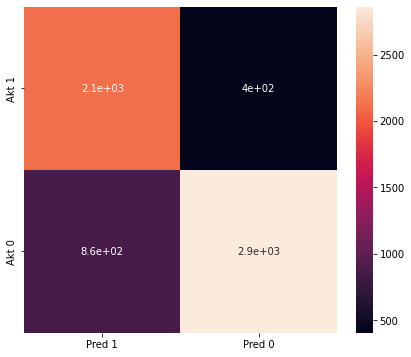

In [193]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_cb,annot=True)

In [194]:
y_test_cb = cb.predict(X_test)

In [195]:
print(classification_report(y_test_cb, y_test))

              precision    recall  f1-score   support

           0       0.81      0.71      0.75       936
           1       0.63      0.75      0.69       627

    accuracy                           0.72      1563
   macro avg       0.72      0.73      0.72      1563
weighted avg       0.74      0.72      0.73      1563



In [196]:
cm_test_cb = confusion_matrix(y_test_gnb, y_test, labels=[1, 0])

In [197]:
df_cm_test_cb = pd.DataFrame(data=cm_test_cb, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_cb

,Pred 1,Pred 0
Akt 1,440,196
Akt 0,307,620


<AxesSubplot:>

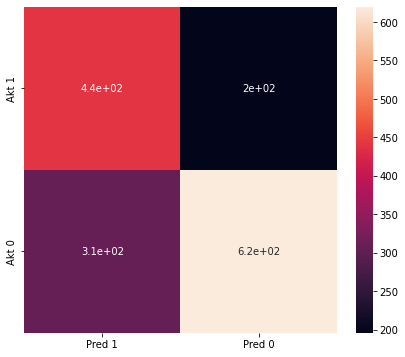

In [198]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_cb,annot=True)

In [199]:
ml_normal = pd.concat([LOG1,KNN1,SVM1,GNB1,DT1,RF1, XGB1, AB1, GB1, CB1], axis=1).T
ml_normal

,Accuracy,Recall,Precision,F1
Log Train,0.669920,0.644556,0.657553,0.650990
Log Test,0.674344,0.659973,0.659091,0.659532
KNN Train,0.730560,0.675377,0.738191,0.705388
KNN Test,0.606526,0.552878,0.595101,0.573213
SVM Train,0.566560,0.385595,0.568115,0.459389
SVM Test,0.607806,0.427041,0.632937,0.509992
Naive Bayes Train,0.648640,0.568509,0.651440,0.607156
Naive Bayes Test,0.678183,0.589023,0.691824,0.636298
Decision Tree Train,0.999680,0.999330,1.000000,0.999665
Decision Tree Test,0.618042,0.603748,0.599734,0.601734


## Improvment using scalar

In [200]:
sc = RobustScaler()

In [201]:
X_train_sc = sc.fit_transform(X_train)

In [202]:
X_test_sc = sc.fit_transform(X_test)

## Logistic Regression

In [203]:
LR_sc = LogisticRegression()

In [204]:
LR_sc.fit(X_train_sc, y_train)

LogisticRegression()

In [205]:
LR_sc_Acc_train, LR_sc_Rec_train, LR_sc_Prec_train, LR_sc_F1_train = Eva_Matrix(LR_sc, X_train_sc, y_train)

In [206]:
LR_sc_Acc_test, LR_sc_Rec_test, LR_sc_Prec_test, LR_sc_F1_test = Eva_Matrix(LR_sc, X_test_sc, y_test)

In [207]:
data_log_sc = {
    "Log SC Train" : [LR_sc_Acc_train, LR_sc_Rec_train, LR_sc_Prec_train, LR_sc_F1_train],
    "Log SC Test" : [LR_sc_Acc_test, LR_sc_Rec_test, LR_sc_Prec_test, LR_sc_F1_test]
}

In [208]:
LOG2 = pd.DataFrame(data=data_log_sc, index = ['Accuracy','Recall','Precision','F1'])
LOG2

,Log SC Train,Log SC Test
Accuracy,0.679680,0.688420
Recall,0.626466,0.639893
Precision,0.678273,0.686782
F1,0.651341,0.662509


In [209]:
y_train_log_sc = LR_sc.predict(X_train_sc)

In [210]:
print(classification_report(y_train_log_sc, y_train))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70      3493
           1       0.63      0.68      0.65      2757

    accuracy                           0.68      6250
   macro avg       0.68      0.68      0.68      6250
weighted avg       0.68      0.68      0.68      6250



In [211]:
cm_train_log_sc = confusion_matrix(y_train_log_sc, y_train, labels=[1, 0])

In [212]:
df_cm_train_log_sc = pd.DataFrame(data=cm_train_log_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_log_sc

,Pred 1,Pred 0
Akt 1,1870,887
Akt 0,1115,2378


<AxesSubplot:>

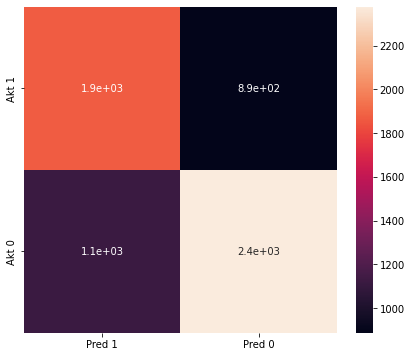

In [213]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_log_sc,annot=True)

In [214]:
y_test_log_sc = LR_sc.predict(X_test_sc)

In [215]:
print(classification_report(y_test_log_sc, y_test))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       867
           1       0.64      0.69      0.66       696

    accuracy                           0.69      1563
   macro avg       0.69      0.69      0.69      1563
weighted avg       0.69      0.69      0.69      1563



In [216]:
cm_test_log_sc = confusion_matrix(y_test_log_sc, y_test, labels=[1, 0])

In [217]:
df_cm_test_log_sc = pd.DataFrame(data=cm_test_log_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_log_sc

,Pred 1,Pred 0
Akt 1,478,218
Akt 0,269,598


<AxesSubplot:>

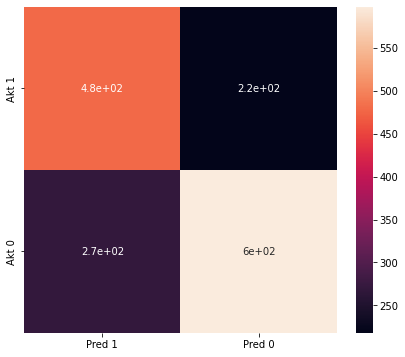

In [218]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_log_sc,annot=True)

## KNN

In [219]:
KNN_sc = KNeighborsClassifier()

In [220]:
KNN_sc.fit(X_train_sc, y_train)

KNeighborsClassifier()

In [221]:
KNN_sc_Acc_train, KNN_sc_Rec_train, KNN_sc_Prec_train, KNN_sc_F1_train = Eva_Matrix(KNN_sc, X_train_sc, y_train)

In [222]:
KNN_sc_Acc_test, KNN_sc_Rec_test, KNN_sc_Prec_test, KNN_sc_F1_test = Eva_Matrix(KNN_sc, X_test_sc, y_test)

In [223]:
data_knn_sc = {
    "KNN SC Train" : [KNN_sc_Acc_train, KNN_sc_Rec_train, KNN_sc_Prec_train, KNN_sc_F1_train],
    "KNN SC Test" : [KNN_sc_Acc_test, KNN_sc_Rec_test, KNN_sc_Prec_test, KNN_sc_F1_test]
}

In [224]:
KNN2 = pd.DataFrame(data=data_knn_sc, index = ['Accuracy','Recall','Precision','F1'])
KNN2

,KNN SC Train,KNN SC Test
Accuracy,0.776160,0.660909
Recall,0.717588,0.621151
Precision,0.793921,0.652602
F1,0.753827,0.636488


In [225]:
y_train_knn_sc = KNN_sc.predict(X_train_sc)

In [226]:
print(classification_report(y_train_knn_sc, y_train))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      3552
           1       0.72      0.79      0.75      2698

    accuracy                           0.78      6250
   macro avg       0.77      0.78      0.77      6250
weighted avg       0.78      0.78      0.78      6250



In [227]:
cm_train_knn_sc = confusion_matrix(y_train_knn_sc, y_train, labels=[1, 0])

In [228]:
df_cm_train_knn_sc = pd.DataFrame(data=cm_train_knn_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_knn_sc

,Pred 1,Pred 0
Akt 1,2142,556
Akt 0,843,2709


<AxesSubplot:>

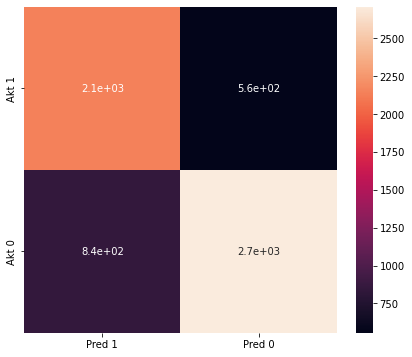

In [229]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_knn_sc,annot=True)

In [230]:
y_test_knn_sc = KNN_sc.predict(X_test_sc)

In [231]:
print(classification_report(y_test_knn_sc, y_test))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       852
           1       0.62      0.65      0.64       711

    accuracy                           0.66      1563
   macro avg       0.66      0.66      0.66      1563
weighted avg       0.66      0.66      0.66      1563



In [232]:
cm_test_knn_sc = confusion_matrix(y_test_knn_sc, y_test, labels=[1, 0])

In [233]:
df_cm_test_knn_sc = pd.DataFrame(data=cm_test_knn_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_knn_sc

,Pred 1,Pred 0
Akt 1,464,247
Akt 0,283,569


<AxesSubplot:>

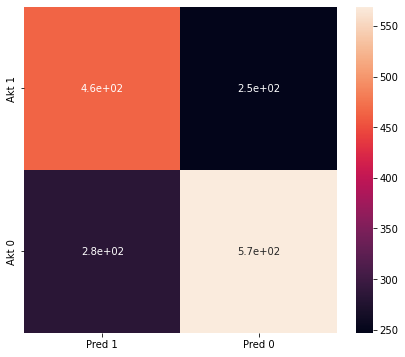

In [234]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_knn_sc,annot=True)

## SVM

In [235]:
SVM_sc = SVC()

In [236]:
SVM_sc.fit(X_train_sc, y_train)

SVC()

In [237]:
SVM_sc_Acc_train, SVM_sc_Rec_train, SVM_sc_Prec_train, SVM_sc_F1_train = Eva_Matrix(SVM_sc, X_train_sc, y_train)

In [238]:
SVM_sc_Acc_test, SVM_sc_Rec_test, SVM_sc_Prec_test, SVM_sc_F1_test = Eva_Matrix(SVM_sc, X_test_sc, y_test)

In [239]:
data_svm_sc = {
    "SVM SC Train" : [SVM_sc_Acc_train, SVM_sc_Rec_train, SVM_sc_Prec_train, SVM_sc_F1_train],
    "SVM SC Test" : [SVM_sc_Acc_test, SVM_sc_Rec_test, SVM_sc_Prec_test, SVM_sc_F1_test]
}

In [240]:
SVM2 = pd.DataFrame(data=data_svm_sc, index = ['Accuracy','Recall','Precision','F1'])
SVM2

,SVM SC Train,SVM SC Test
Accuracy,0.720640,0.701216
Recall,0.602010,0.646586
Precision,0.763057,0.704082
F1,0.673034,0.674110


In [241]:
y_train_svm_sc = SVM_sc.predict(X_train_sc)

In [242]:
print(classification_report(y_train_svm_sc, y_train))

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      3895
           1       0.60      0.76      0.67      2355

    accuracy                           0.72      6250
   macro avg       0.72      0.73      0.71      6250
weighted avg       0.74      0.72      0.72      6250



In [243]:
cm_train_svm_sc = confusion_matrix(y_train_svm_sc, y_train, labels=[1, 0])

In [244]:
df_cm_train_svm_sc = pd.DataFrame(data=cm_train_svm_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_svm_sc

,Pred 1,Pred 0
Akt 1,1797,558
Akt 0,1188,2707


<AxesSubplot:>

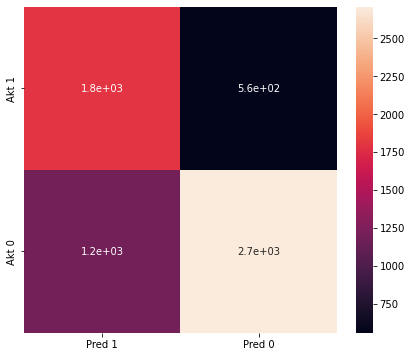

In [245]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_svm_sc,annot=True)

In [246]:
y_test_svm_sc = SVM_sc.predict(X_test_sc)

In [247]:
print(classification_report(y_test_svm_sc, y_test))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72       877
           1       0.65      0.70      0.67       686

    accuracy                           0.70      1563
   macro avg       0.70      0.70      0.70      1563
weighted avg       0.71      0.70      0.70      1563



In [248]:
cm_test_svm_sc = confusion_matrix(y_test_svm_sc, y_test, labels=[1, 0])

In [249]:
df_cm_test_svm_sc = pd.DataFrame(data=cm_test_svm_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_svm_sc

,Pred 1,Pred 0
Akt 1,483,203
Akt 0,264,613


<AxesSubplot:>

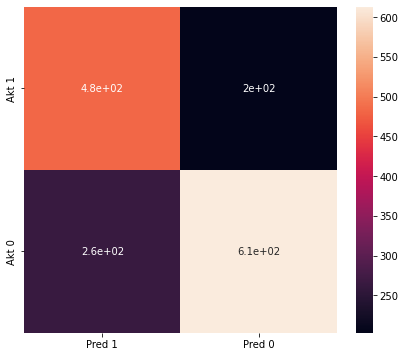

In [250]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_svm_sc,annot=True)

## Naive Bayes

In [251]:
gnb_sc = GaussianNB()

In [252]:
gnb_sc.fit(X_train_sc, y_train)

GaussianNB()

In [253]:
NB_sc_Acc_train, NB_sc_Rec_train, NB_sc_Prec_train, NB_sc_F1_train = Eva_Matrix(gnb_sc, X_train_sc, y_train)

In [254]:
NB_sc_Acc_test, NB_sc_Rec_test, NB_sc_Prec_test, NB_sc_F1_test = Eva_Matrix(gnb_sc, X_test_sc, y_test)

In [255]:
data_nb_sc = {
    "Naive Bayes SC Train" : [NB_sc_Acc_train, NB_sc_Rec_train, NB_sc_Prec_train, NB_sc_F1_train],
    "Naive Bayes SC Test" : [NB_sc_Acc_test, NB_sc_Rec_test, NB_sc_Prec_test, NB_sc_F1_test]
}

In [256]:
GNB2 = pd.DataFrame(data=data_nb_sc, index = ['Accuracy','Recall','Precision','F1'])
GNB2

,Naive Bayes SC Train,Naive Bayes SC Test
Accuracy,0.648480,0.671785
Recall,0.532998,0.566265
Precision,0.664578,0.691176
F1,0.591560,0.622517


In [257]:
y_train_nb_sc = gnb_sc.predict(X_train_sc)

In [258]:
print(classification_report(y_train_nb_sc, y_train))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69      3856
           1       0.53      0.66      0.59      2394

    accuracy                           0.65      6250
   macro avg       0.64      0.65      0.64      6250
weighted avg       0.67      0.65      0.65      6250



In [259]:
cm_train_nb_sc = confusion_matrix(y_train_nb_sc, y_train, labels=[1, 0])

In [260]:
df_cm_train_nb_sc = pd.DataFrame(data=cm_train_nb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_nb_sc

,Pred 1,Pred 0
Akt 1,1591,803
Akt 0,1394,2462


<AxesSubplot:>

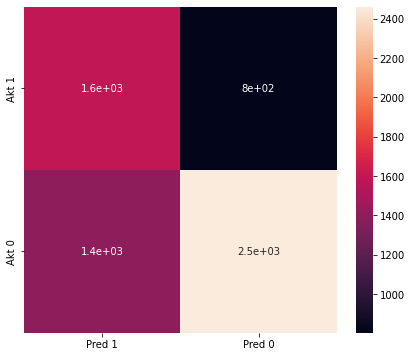

In [261]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_nb_sc,annot=True)

In [262]:
y_test_nb_sc = gnb_sc.predict(X_test_sc)

In [263]:
print(classification_report(y_test_nb_sc, y_test))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71       951
           1       0.57      0.69      0.62       612

    accuracy                           0.67      1563
   macro avg       0.67      0.68      0.67      1563
weighted avg       0.69      0.67      0.68      1563



In [264]:
cm_test_nb_sc = confusion_matrix(y_test_nb_sc, y_test, labels=[1, 0])

In [265]:
df_cm_test_nb_sc = pd.DataFrame(data=cm_test_nb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_nb_sc

,Pred 1,Pred 0
Akt 1,423,189
Akt 0,324,627


<AxesSubplot:>

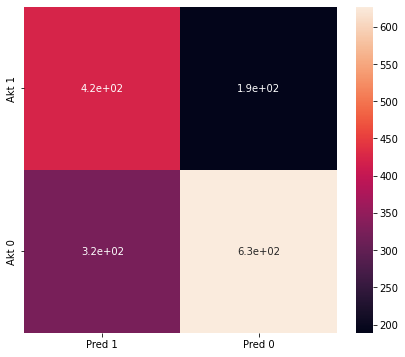

In [266]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_nb_sc,annot=True)

## Decision Tree

In [267]:
DT_sc = DecisionTreeClassifier()

In [268]:
DT_sc.fit(X_train_sc, y_train)

DecisionTreeClassifier()

In [269]:
DT_sc_Acc_train, DT_sc_Rec_train, DT_sc_Prec_train, DT_sc_F1_train = Eva_Matrix(DT_sc, X_train_sc, y_train)

In [270]:
DT_sc_Acc_test, DT_sc_Rec_test, DT_sc_Prec_test, DT_sc_F1_test = Eva_Matrix(DT_sc, X_test_sc, y_test)

In [271]:
data_dt_sc = {
    "Decision Tree SC Train" : [DT_sc_Acc_train, DT_sc_Rec_train, DT_sc_Prec_train, DT_sc_F1_train],
    "Decision Tree SC Test" : [DT_sc_Acc_test, DT_sc_Rec_test, DT_sc_Prec_test, DT_sc_F1_test]
}

In [272]:
DT2 = pd.DataFrame(data=data_dt_sc, index = ['Accuracy','Recall','Precision','F1'])
DT2

,Decision Tree SC Train,Decision Tree SC Test
Accuracy,0.999680,0.615483
Recall,0.999330,0.619813
Precision,1.000000,0.593590
F1,0.999665,0.606418


In [273]:
y_train_dt_sc = DT_sc.predict(X_train_sc)

In [274]:
print(classification_report(y_train_dt_sc, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3267
           1       1.00      1.00      1.00      2983

    accuracy                           1.00      6250
   macro avg       1.00      1.00      1.00      6250
weighted avg       1.00      1.00      1.00      6250



In [275]:
cm_train_dt_sc = confusion_matrix(y_train_dt_sc, y_train, labels=[1, 0])

In [276]:
df_cm_train_dt_sc = pd.DataFrame(data=cm_train_dt_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_dt_sc

,Pred 1,Pred 0
Akt 1,2983,0
Akt 0,2,3265


<AxesSubplot:>

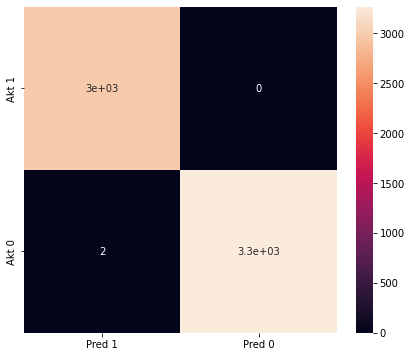

In [277]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_dt_sc,annot=True)

In [278]:
y_test_dt_sc = DT_sc.predict(X_test_sc)

In [279]:
print(classification_report(y_test_dt_sc, y_test))

              precision    recall  f1-score   support

           0       0.61      0.64      0.62       783
           1       0.62      0.59      0.61       780

    accuracy                           0.62      1563
   macro avg       0.62      0.62      0.62      1563
weighted avg       0.62      0.62      0.62      1563



In [280]:
cm_test_dt_sc = confusion_matrix(y_test_dt_sc, y_test, labels=[1, 0])

In [281]:
df_cm_test_dt_sc = pd.DataFrame(data=cm_test_dt_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_dt_sc

,Pred 1,Pred 0
Akt 1,463,317
Akt 0,284,499


<AxesSubplot:>

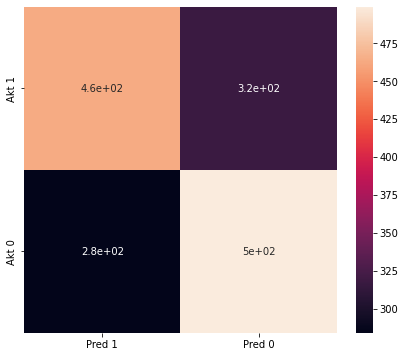

In [282]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_dt_sc,annot=True)

## Random Forest

In [283]:
RF_sc = RandomForestClassifier()

In [284]:
RF_sc.fit(X_train_sc, y_train)

RandomForestClassifier()

In [285]:
RF_sc_Acc_train, RF_sc_Rec_train, RF_sc_Prec_train, RF_sc_F1_train = Eva_Matrix(RF_sc, X_train_sc, y_train)

In [286]:
RF_sc_Acc_test, RF_sc_Rec_test, RF_sc_Prec_test, RF_sc_F1_test = Eva_Matrix(RF_sc, X_test_sc, y_test)

In [287]:
data_rf_sc = {
    "Random Forest SC Train" : [RF_sc_Acc_train, RF_sc_Rec_train, RF_sc_Prec_train, RF_sc_F1_train],
    "Random Forest SC Test" : [RF_sc_Acc_test, RF_sc_Rec_test, RF_sc_Prec_test, RF_sc_F1_test]
}

In [288]:
RF2 = pd.DataFrame(data=data_rf_sc, index = ['Accuracy','Recall','Precision','F1'])
RF2

,Random Forest SC Train,Random Forest SC Test
Accuracy,0.999680,0.688420
Recall,0.999330,0.666667
Precision,1.000000,0.676630
F1,0.999665,0.671612


In [289]:
y_train_rf_sc = RF_sc.predict(X_train_sc)

In [290]:
print(classification_report(y_train_rf_sc, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3267
           1       1.00      1.00      1.00      2983

    accuracy                           1.00      6250
   macro avg       1.00      1.00      1.00      6250
weighted avg       1.00      1.00      1.00      6250



In [291]:
cm_train_rf_sc = confusion_matrix(y_train_rf_sc, y_train, labels=[1, 0])

In [292]:
df_cm_train_rf_sc = pd.DataFrame(data=cm_train_rf_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_rf_sc

,Pred 1,Pred 0
Akt 1,2983,0
Akt 0,2,3265


<AxesSubplot:>

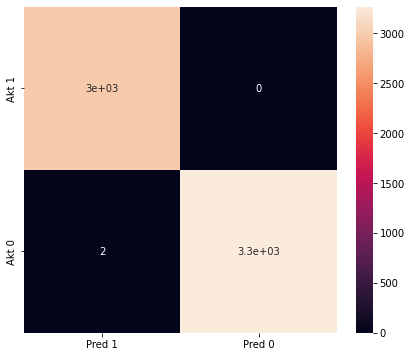

In [293]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_rf_sc,annot=True)

In [294]:
y_test_rf_sc = DT_sc.predict(X_test_sc)

In [295]:
print(classification_report(y_test_rf_sc, y_test))

              precision    recall  f1-score   support

           0       0.61      0.64      0.62       783
           1       0.62      0.59      0.61       780

    accuracy                           0.62      1563
   macro avg       0.62      0.62      0.62      1563
weighted avg       0.62      0.62      0.62      1563



In [296]:
cm_test_rf_sc = confusion_matrix(y_test_dt_sc, y_test, labels=[1, 0])

In [297]:
df_cm_test_rf_sc = pd.DataFrame(data=cm_test_rf_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_rf_sc

,Pred 1,Pred 0
Akt 1,463,317
Akt 0,284,499


<AxesSubplot:>

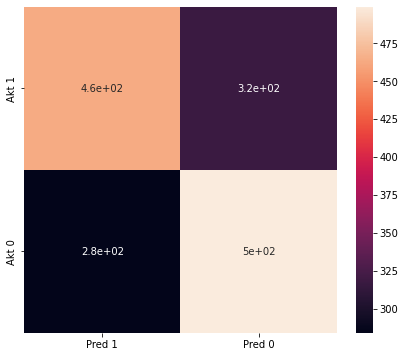

In [298]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_rf_sc,annot=True)

## XGB

In [299]:
XGB_sc = XGBClassifier()

In [300]:
XGB_sc.fit(X_train_sc, y_train)

[19:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [301]:
XGB_sc_Acc_train, XGB_sc_Rec_train, XGB_sc_Prec_train, XGB_sc_F1_train = Eva_Matrix(XGB_sc, X_train_sc, y_train)

In [302]:
XGB_sc_Acc_test, XGB_sc_Rec_test, XGB_sc_Prec_test, XGB_sc_F1_test = Eva_Matrix(XGB_sc, X_test_sc, y_test)

In [303]:
data_xgb_sc = {
    "XGB SC Train" : [XGB_sc_Acc_train, XGB_sc_Rec_train, XGB_sc_Prec_train, XGB_sc_F1_train],
    "XGB SC Test" : [XGB_sc_Acc_test, XGB_sc_Rec_test, XGB_sc_Prec_test, XGB_sc_F1_test]
}

In [304]:
XGB2 = pd.DataFrame(data=data_xgb_sc, index = ['Accuracy','Recall','Precision','F1'])
XGB2

,XGB SC Train,XGB SC Test
Accuracy,0.881440,0.676264
Recall,0.821106,0.654618
Precision,0.922122,0.663501
F1,0.868687,0.659030


In [305]:
y_train_xgb_sc = XGB_sc.predict(X_train_sc)

In [306]:
print(classification_report(y_train_xgb_sc, y_train))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3592
           1       0.82      0.92      0.87      2658

    accuracy                           0.88      6250
   macro avg       0.88      0.89      0.88      6250
weighted avg       0.89      0.88      0.88      6250



In [307]:
cm_train_xgb_sc = confusion_matrix(y_train_xgb_sc, y_train, labels=[1, 0])

In [308]:
df_cm_train_xgb_sc = pd.DataFrame(data=cm_train_xgb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_xgb_sc

,Pred 1,Pred 0
Akt 1,2451,207
Akt 0,534,3058


<AxesSubplot:>

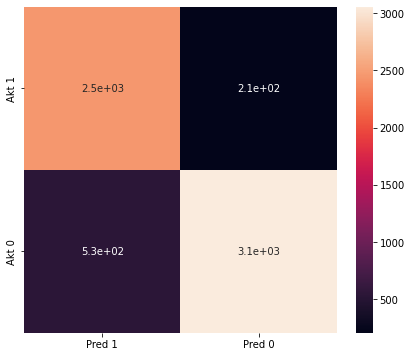

In [309]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_xgb_sc,annot=True)

In [310]:
y_test_xgb_sc = XGB_sc.predict(X_test_sc)

In [311]:
print(classification_report(y_test_xgb_sc, y_test))

              precision    recall  f1-score   support

           0       0.70      0.69      0.69       826
           1       0.65      0.66      0.66       737

    accuracy                           0.68      1563
   macro avg       0.68      0.68      0.68      1563
weighted avg       0.68      0.68      0.68      1563



In [312]:
cm_test_xgb_sc = confusion_matrix(y_test_xgb_sc, y_test, labels=[1, 0])

In [313]:
df_cm_test_xgb_sc = pd.DataFrame(data=cm_test_xgb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_xgb_sc

,Pred 1,Pred 0
Akt 1,489,248
Akt 0,258,568


<AxesSubplot:>

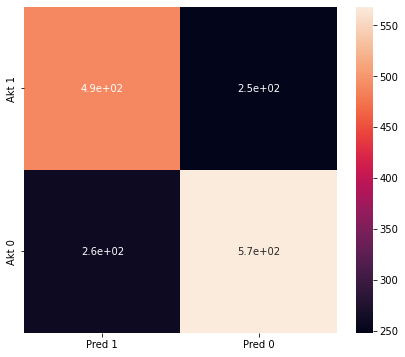

In [314]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_xgb_sc,annot=True)

## Ada Boost

In [315]:
AB_sc = AdaBoostClassifier()

In [316]:
AB_sc.fit(X_train_sc, y_train)

AdaBoostClassifier()

In [317]:
AB_sc_Acc_train, AB_sc_Rec_train, AB_sc_Prec_train, AB_sc_F1_train = Eva_Matrix(AB_sc, X_train_sc, y_train)

In [318]:
AB_sc_Acc_test, AB_sc_Rec_test, AB_sc_Prec_test, AB_sc_F1_test = Eva_Matrix(AB_sc, X_test_sc, y_test)

In [319]:
data_ab_sc = {
    "Ada Boost SC Train" : [AB_sc_Acc_train, AB_sc_Rec_train, AB_sc_Prec_train, AB_sc_F1_train],
    "Ada Boost SC Test" : [AB_sc_Acc_test, AB_sc_Rec_test, AB_sc_Prec_test, AB_sc_F1_test]
}

In [320]:
AB2 = pd.DataFrame(data=data_ab_sc, index = ['Accuracy','Recall','Precision','F1'])
AB2

,Ada Boost SC Train,Ada Boost SC Test
Accuracy,0.701280,0.687140
Recall,0.624456,0.678715
Precision,0.714176,0.670635
F1,0.666309,0.674651


In [321]:
y_train_ab_sc = AB_sc.predict(X_train_sc)

In [322]:
print(classification_report(y_train_ab_sc, y_train))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      3640
           1       0.62      0.71      0.67      2610

    accuracy                           0.70      6250
   macro avg       0.70      0.70      0.70      6250
weighted avg       0.71      0.70      0.70      6250



In [323]:
cm_train_ab_sc = confusion_matrix(y_train_ab_sc, y_train, labels=[1, 0])

In [324]:
df_cm_train_ab_sc = pd.DataFrame(data=cm_train_ab_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_ab_sc

,Pred 1,Pred 0
Akt 1,1864,746
Akt 0,1121,2519


<AxesSubplot:>

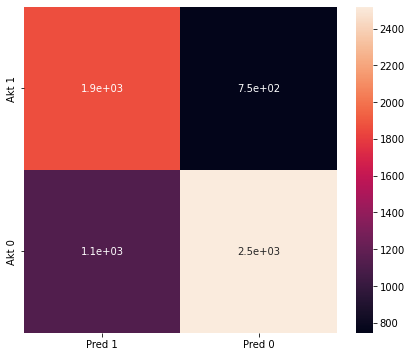

In [325]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_ab_sc,annot=True)

In [326]:
y_test_ab_sc = AB_sc.predict(X_test_sc)

In [327]:
print(classification_report(y_test_ab_sc, y_test))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       807
           1       0.68      0.67      0.67       756

    accuracy                           0.69      1563
   macro avg       0.69      0.69      0.69      1563
weighted avg       0.69      0.69      0.69      1563



In [328]:
cm_test_ab_sc = confusion_matrix(y_test_ab_sc, y_test, labels=[1, 0])

In [329]:
df_cm_test_ab_sc = pd.DataFrame(data=cm_test_ab_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_ab_sc

,Pred 1,Pred 0
Akt 1,507,249
Akt 0,240,567


<AxesSubplot:>

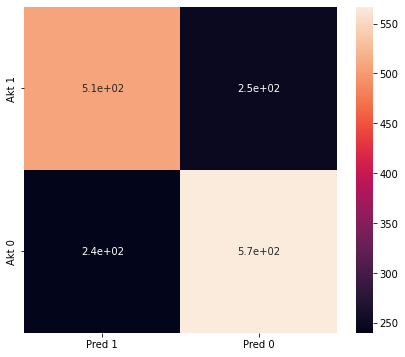

In [330]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_ab_sc,annot=True)

## Gradient Boost

In [331]:
GB_sc = GradientBoostingClassifier()

In [332]:
GB_sc.fit(X_train_sc, y_train)

GradientBoostingClassifier()

In [333]:
GB_sc_Acc_train, GB_sc_Rec_train, GB_sc_Prec_train, GB_sc_F1_train = Eva_Matrix(GB_sc, X_train_sc, y_train)

In [334]:
GB_sc_Acc_test, GB_sc_Rec_test, GB_sc_Prec_test, GB_sc_F1_test = Eva_Matrix(GB_sc, X_test_sc, y_test)

In [335]:
data_gb_sc = {
    "Gradient Boost SC Train" : [GB_sc_Acc_train, GB_sc_Rec_train, GB_sc_Prec_train, GB_sc_F1_train],
    "Gradient Boost SC Test" : [GB_sc_Acc_test, GB_sc_Rec_test, GB_sc_Prec_test, GB_sc_F1_test]
}

In [336]:
GB2 = pd.DataFrame(data=data_gb_sc, index = ['Accuracy','Recall','Precision','F1'])
GB2

,Gradient Boost SC Train,Gradient Boost SC Test
Accuracy,0.728640,0.695457
Recall,0.633166,0.653280
Precision,0.758731,0.692199
F1,0.690285,0.672176


In [337]:
y_train_gb_sc = GB_sc.predict(X_train_sc)

In [338]:
print(classification_report(y_train_gb_sc, y_train))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      3759
           1       0.63      0.76      0.69      2491

    accuracy                           0.73      6250
   macro avg       0.72      0.73      0.72      6250
weighted avg       0.74      0.73      0.73      6250



In [339]:
cm_train_gb_sc = confusion_matrix(y_train_gb_sc, y_train, labels=[1, 0])

In [340]:
df_cm_train_gb_sc = pd.DataFrame(data=cm_train_gb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_gb_sc

,Pred 1,Pred 0
Akt 1,1890,601
Akt 0,1095,2664


<AxesSubplot:>

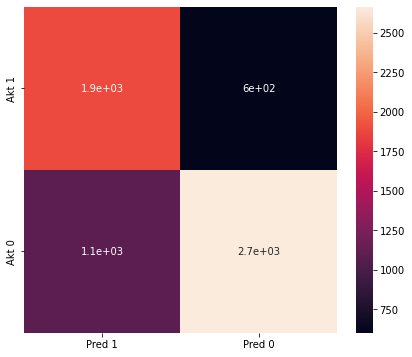

In [341]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_gb_sc,annot=True)

In [342]:
y_test_gb_sc = GB_sc.predict(X_test_sc)

In [343]:
print(classification_report(y_test_gb_sc, y_test))

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       858
           1       0.65      0.69      0.67       705

    accuracy                           0.70      1563
   macro avg       0.69      0.70      0.69      1563
weighted avg       0.70      0.70      0.70      1563



In [344]:
cm_test_gb_sc = confusion_matrix(y_test_gb_sc, y_test, labels=[1, 0])

In [345]:
df_cm_test_gb_sc = pd.DataFrame(data=cm_test_gb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_gb_sc

,Pred 1,Pred 0
Akt 1,488,217
Akt 0,259,599


<AxesSubplot:>

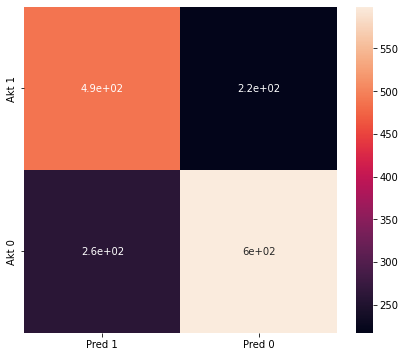

In [346]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_gb_sc,annot=True)

## Cat Boost

In [347]:
CB_sc = CatBoostClassifier()

In [348]:
CB_sc.fit(X_train_sc, y_train)

Learning rate set to 0.022531
0:	learn: 0.6885552	total: 8.19ms	remaining: 8.18s
1:	learn: 0.6838993	total: 12.2ms	remaining: 6.08s
2:	learn: 0.6796687	total: 16ms	remaining: 5.33s
3:	learn: 0.6754920	total: 20ms	remaining: 4.97s
4:	learn: 0.6713465	total: 23.4ms	remaining: 4.66s
5:	learn: 0.6675218	total: 27.4ms	remaining: 4.53s
6:	learn: 0.6638661	total: 31.4ms	remaining: 4.46s
7:	learn: 0.6602582	total: 35.3ms	remaining: 4.38s
8:	learn: 0.6565115	total: 38.7ms	remaining: 4.26s
9:	learn: 0.6533738	total: 42.3ms	remaining: 4.19s
10:	learn: 0.6504659	total: 47.3ms	remaining: 4.25s
11:	learn: 0.6473288	total: 52.1ms	remaining: 4.29s
12:	learn: 0.6448283	total: 56.1ms	remaining: 4.26s
13:	learn: 0.6421042	total: 60.1ms	remaining: 4.23s
14:	learn: 0.6397858	total: 63.9ms	remaining: 4.19s
15:	learn: 0.6373443	total: 67.8ms	remaining: 4.17s
16:	learn: 0.6352426	total: 71.6ms	remaining: 4.14s
17:	learn: 0.6329983	total: 75.8ms	remaining: 4.13s
18:	learn: 0.6305263	total: 80.2ms	remaining: 4.

In [349]:
CB_sc_Acc_train, CB_sc_Rec_train, CB_sc_Prec_train, CB_sc_F1_train = Eva_Matrix(CB_sc, X_train_sc, y_train)

In [350]:
CB_sc_Acc_test, CB_sc_Rec_test, CB_sc_Prec_test, CB_sc_F1_test = Eva_Matrix(CB_sc, X_test_sc, y_test)

In [351]:
data_cb_sc = {
    "Cat Boost SC Train" : [CB_sc_Acc_train, CB_sc_Rec_train, CB_sc_Prec_train, CB_sc_F1_train],
    "Cat Boost SC Test" : [CB_sc_Acc_test, CB_sc_Rec_test, CB_sc_Prec_test, CB_sc_F1_test]
}

In [352]:
CB2 = pd.DataFrame(data=data_cb_sc, index = ['Accuracy','Recall','Precision','F1'])
CB2

,Cat Boost SC Train,Cat Boost SC Test
Accuracy,0.796960,0.709533
Recall,0.710218,0.678715
Precision,0.839937,0.703190
F1,0.769650,0.690736


In [353]:
y_train_cb_sc = CB_sc.predict(X_train_sc)

In [354]:
print(classification_report(y_train_cb_sc, y_train))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3726
           1       0.71      0.84      0.77      2524

    accuracy                           0.80      6250
   macro avg       0.79      0.80      0.79      6250
weighted avg       0.81      0.80      0.80      6250



In [355]:
cm_train_cb_sc = confusion_matrix(y_train_cb_sc, y_train, labels=[1, 0])

In [356]:
df_cm_train_cb_sc = pd.DataFrame(data=cm_train_cb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_cb_sc

,Pred 1,Pred 0
Akt 1,2120,404
Akt 0,865,2861


<AxesSubplot:>

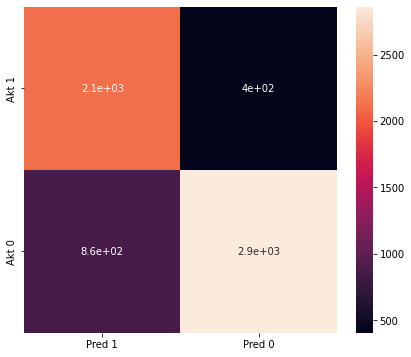

In [357]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_cb_sc,annot=True)

In [358]:
y_test_cb_sc = CB_sc.predict(X_test_sc)

In [359]:
print(classification_report(y_test_cb_sc, y_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.73       842
           1       0.68      0.70      0.69       721

    accuracy                           0.71      1563
   macro avg       0.71      0.71      0.71      1563
weighted avg       0.71      0.71      0.71      1563



In [360]:
cm_test_cb_sc = confusion_matrix(y_test_cb_sc, y_test, labels=[1, 0])

In [361]:
df_cm_test_cb_sc = pd.DataFrame(data=cm_test_cb_sc, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_cb_sc

,Pred 1,Pred 0
Akt 1,507,214
Akt 0,240,602


<AxesSubplot:>

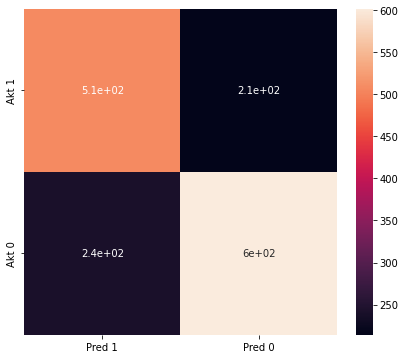

In [362]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_cb_sc,annot=True)

In [363]:
ml_sc = pd.concat([LOG2,KNN2,SVM2,GNB2,DT2,RF2, XGB2, AB2, GB2, CB2], axis=1).T
ml_sc

,Accuracy,Recall,Precision,F1
Log SC Train,0.679680,0.626466,0.678273,0.651341
Log SC Test,0.688420,0.639893,0.686782,0.662509
KNN SC Train,0.776160,0.717588,0.793921,0.753827
KNN SC Test,0.660909,0.621151,0.652602,0.636488
SVM SC Train,0.720640,0.602010,0.763057,0.673034
SVM SC Test,0.701216,0.646586,0.704082,0.674110
Naive Bayes SC Train,0.648480,0.532998,0.664578,0.591560
Naive Bayes SC Test,0.671785,0.566265,0.691176,0.622517
Decision Tree SC Train,0.999680,0.999330,1.000000,0.999665
Decision Tree SC Test,0.615483,0.619813,0.593590,0.606418


## Improvement Tuning 

In [37]:
rbs = RobustScaler()

In [38]:
rbs.fit(X_train)

RobustScaler()

In [39]:
X_train_sc = rbs.transform(X_train)
X_test_sc = rbs.transform(X_test)

In [40]:
skf = StratifiedKFold(n_splits=4)

## Logistic Regression

In [368]:
LR_Tuned = LogisticRegression()

In [369]:
param_LR = {
    'C' : np.arange(1, 700, 0.1), 
    'penalty' : ['l1','l2','elasticnet'],
}

In [370]:
GS_LR = GridSearchCV(LR_Tuned, param_LR, cv = skf, n_jobs=-1, verbose=1, scoring = 'accuracy')

In [371]:
GS_LR.fit(X_train, y_train)

Fitting 4 folds for each of 20970 candidates, totalling 83880 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([  1. ,   1.1,   1.2, ..., 699.7, 699.8, 699.9]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy', verbose=1)

In [372]:
LR_Tuned = GS_LR.best_estimator_

In [373]:
Log_tu_Acc_train, Log_tu_Rec_train, Log_tu_Prec_train, Log_tu_F1_train = Eva_Matrix(LR_Tuned, X_train_sc, y_train)

In [374]:
Log_tu_Acc_test, Log_tu_Rec_test, Log_tu_Prec_test, Log_tu_F1_test = Eva_Matrix(LR_Tuned, X_test_sc, y_test)

In [375]:
data_log_tu = {
    "Log Tuning Train" : [Log_tu_Acc_train, Log_tu_Rec_train, Log_tu_Prec_train, Log_tu_F1_train],
    "Log Tuning Test" : [Log_tu_Acc_test, Log_tu_Rec_test, Log_tu_Prec_test, Log_tu_F1_test]
}

In [376]:
LOG3 = pd.DataFrame(data=data_log_tu, index = ['Accuracy','Recall','Precision','F1'])
LOG3

,Log Tuning Train,Log Tuning Test
Accuracy,0.676000,0.674984
Recall,0.489447,0.489960
Precision,0.744648,0.742394
F1,0.590661,0.590323


In [377]:
y_train_log_tuning = GS_LR.predict(X_train_sc)

In [378]:
print(classification_report(y_train_log_tuning, y_train))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73      4288
           1       0.49      0.74      0.59      1962

    accuracy                           0.68      6250
   macro avg       0.67      0.69      0.66      6250
weighted avg       0.73      0.68      0.69      6250



In [379]:
cm_train_log_tuning = confusion_matrix(y_train_log_tuning, y_train, labels=[1, 0])

In [380]:
df_cm_train_log_tuning = pd.DataFrame(data=cm_train_log_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_log_tuning

,Pred 1,Pred 0
Akt 1,1461,501
Akt 0,1524,2764


<AxesSubplot:>

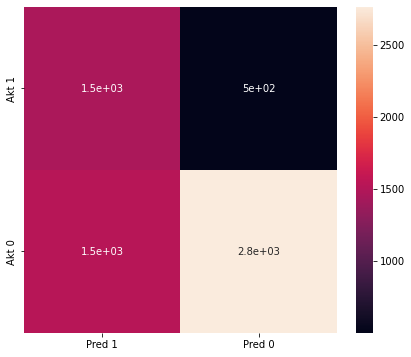

In [381]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_log_tuning,annot=True)

In [382]:
y_test_log_tuning = GS_LR.predict(X_test_sc)

In [383]:
print(classification_report(y_test_log_tuning, y_test))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73      1070
           1       0.49      0.74      0.59       493

    accuracy                           0.67      1563
   macro avg       0.67      0.69      0.66      1563
weighted avg       0.73      0.67      0.69      1563



In [384]:
cm_test_log_tuning = confusion_matrix(y_test_log_tuning, y_test, labels=[1, 0])

In [385]:
df_cm_test_log_tuning = pd.DataFrame(data=cm_test_log_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_log_tuning

,Pred 1,Pred 0
Akt 1,366,127
Akt 0,381,689


<AxesSubplot:>

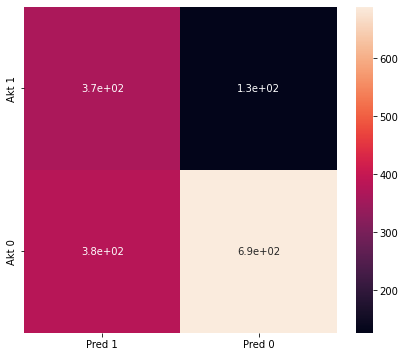

In [386]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_log_tuning,annot=True)

## KNN

In [387]:
KNN_Tuned = KNeighborsClassifier()

In [388]:
param_KNN = {
    "n_neighbors" : np.arange(1, 35, 1),
    'leaf_size' : np.arange(1, 5, 1),
}

In [389]:
KNN_LR = GridSearchCV(KNN_Tuned, param_KNN, cv = skf, n_jobs=-1, verbose=1, scoring = 'accuracy', refit=True )

In [390]:
KNN_LR.fit(X_train, y_train)

Fitting 4 folds for each of 136 candidates, totalling 544 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'leaf_size': array([1, 2, 3, 4]),
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])},
             scoring='accuracy', verbose=1)

In [391]:
KNN_Tuned = KNN_LR.best_estimator_

In [392]:
KNN_tu_Acc_train, KNN_tu_Rec_train, KNN_tu_Prec_train, KNN_tu_F1_train = Eva_Matrix(KNN_Tuned, X_train_sc, y_train)

In [393]:
KNN_tu_Acc_test, KNN_tu_Rec_test, KNN_tu_Prec_test, KNN_tu_F1_test = Eva_Matrix(KNN_Tuned, X_test_sc, y_test)

In [394]:
data_knn_tu = {
    "KNN Tuning Train" : [KNN_tu_Acc_train, KNN_tu_Rec_train, KNN_tu_Prec_train, KNN_tu_F1_train],
    "KNN Tuning Test" : [KNN_tu_Acc_test, KNN_tu_Rec_test, KNN_tu_Prec_test, KNN_tu_F1_test]
}

In [395]:
KNN3 = pd.DataFrame(data=data_knn_tu, index = ['Accuracy','Recall','Precision','F1'])
KNN3

,KNN Tuning Train,KNN Tuning Test
Accuracy,0.525760,0.526552
Recall,0.015410,0.016064
Precision,0.647887,0.705882
F1,0.030105,0.031414


In [396]:
KNN2

,KNN SC Train,KNN SC Test
Accuracy,0.776160,0.660909
Recall,0.717588,0.621151
Precision,0.793921,0.652602
F1,0.753827,0.636488


In [397]:
KNN1

,KNN Train,KNN Test
Accuracy,0.730560,0.606526
Recall,0.675377,0.552878
Precision,0.738191,0.595101
F1,0.705388,0.573213


In [398]:
y_train_knn_tuning = KNN_LR.predict(X_train_sc)

In [399]:
print(classification_report(y_train_knn_tuning, y_train))

              precision    recall  f1-score   support

           0       0.99      0.52      0.69      6179
           1       0.02      0.65      0.03        71

    accuracy                           0.53      6250
   macro avg       0.50      0.59      0.36      6250
weighted avg       0.98      0.53      0.68      6250



In [400]:
cm_train_knn_tuning = confusion_matrix(y_train_knn_tuning, y_train, labels=[1, 0])

In [401]:
df_cm_train_knn_tuning = pd.DataFrame(data=cm_train_knn_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_knn_tuning

,Pred 1,Pred 0
Akt 1,46,25
Akt 0,2939,3240


<AxesSubplot:>

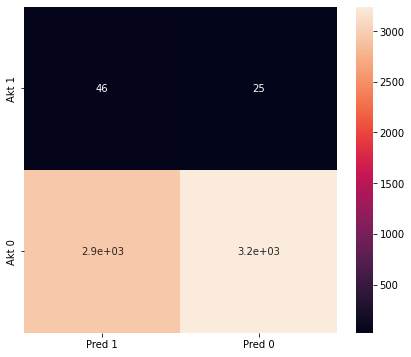

In [402]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_knn_tuning,annot=True)

In [403]:
y_test_knn_tuning = KNN_LR.predict(X_test_sc)

In [404]:
print(classification_report(y_test_knn_tuning, y_test))

              precision    recall  f1-score   support

           0       0.99      0.52      0.69      1546
           1       0.02      0.71      0.03        17

    accuracy                           0.53      1563
   macro avg       0.50      0.62      0.36      1563
weighted avg       0.98      0.53      0.68      1563



In [405]:
cm_test_knn_tuning = confusion_matrix(y_test_knn_tuning, y_test, labels=[1, 0])

In [406]:
df_cm_test_knn_tuning = pd.DataFrame(data=cm_test_knn_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_knn_tuning

,Pred 1,Pred 0
Akt 1,12,5
Akt 0,735,811


<AxesSubplot:>

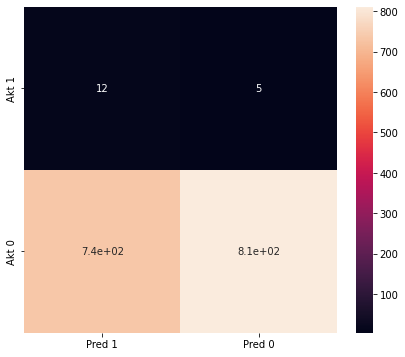

In [407]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_knn_tuning,annot=True)

## SVM

In [408]:
SVM_Tuned = SVC()

In [409]:
param_SVC = {
    "C" : np.arange(1, 40, 2),
    "gamma" : np.arange(1, 40, 1)
}

In [410]:
GS_SVM = GridSearchCV(SVC(), param_SVC, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [411]:
GS_SVM.fit(X_train_sc, y_train)

Fitting 4 folds for each of 780 candidates, totalling 3120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39]),
                         'gamma': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])},
             scoring='accuracy', verbose=1)

In [412]:
SVM_Tuned = GS_SVM.best_estimator_

In [413]:
SVM_tu_Acc_train, SVM_tu_Rec_train, SVM_tu_Prec_train, SVM_tu_F1_train = Eva_Matrix(SVM_Tuned, X_train_sc, y_train)

In [414]:
SVM_tu_Acc_test, SVM_tu_Rec_test, SVM_tu_Prec_test, SVM_tu_F1_test = Eva_Matrix(SVM_Tuned, X_test_sc, y_test)

In [415]:
data_svm_tu = {
    "SVM Tuning Train" : [SVM_tu_Acc_train, SVM_tu_Rec_train, SVM_tu_Prec_train, SVM_tu_F1_train],
    "SVM Tuning Test" : [SVM_tu_Acc_test, SVM_tu_Rec_test, SVM_tu_Prec_test, SVM_tu_F1_test]
}

In [416]:
SVM3 = pd.DataFrame(data=data_svm_tu, index = ['Accuracy','Recall','Precision','F1'])
SVM3

,SVM Tuning Train,SVM Tuning Test
Accuracy,0.875360,0.688420
Recall,0.807370,0.672021
Precision,0.921959,0.674731
F1,0.860868,0.673374


In [417]:
SVM2

,SVM SC Train,SVM SC Test
Accuracy,0.720640,0.701216
Recall,0.602010,0.646586
Precision,0.763057,0.704082
F1,0.673034,0.674110


In [418]:
SVM1

,SVM Train,SVM Test
Accuracy,0.566560,0.607806
Recall,0.385595,0.427041
Precision,0.568115,0.632937
F1,0.459389,0.509992


In [419]:
y_train_svm_tuning = GS_SVM.predict(X_train_sc)

In [420]:
print(classification_report(y_train_svm_tuning, y_train))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3636
           1       0.81      0.92      0.86      2614

    accuracy                           0.88      6250
   macro avg       0.87      0.88      0.87      6250
weighted avg       0.88      0.88      0.88      6250



In [421]:
cm_train_svm_tuning = confusion_matrix(y_train_svm_tuning, y_train, labels=[1, 0])

In [422]:
df_cm_train_svm_tuning = pd.DataFrame(data=cm_train_svm_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_svm_tuning

,Pred 1,Pred 0
Akt 1,2410,204
Akt 0,575,3061


<AxesSubplot:>

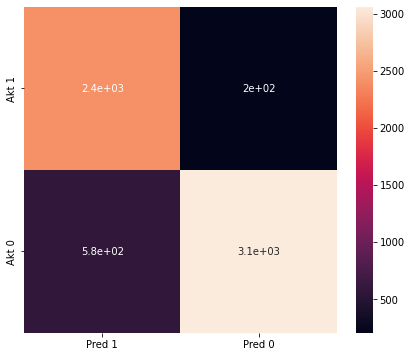

In [423]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_svm_tuning,annot=True)

In [424]:
y_test_svm_tuning = GS_SVM.predict(X_test_sc)

In [425]:
print(classification_report(y_test_svm_tuning, y_test))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       819
           1       0.67      0.67      0.67       744

    accuracy                           0.69      1563
   macro avg       0.69      0.69      0.69      1563
weighted avg       0.69      0.69      0.69      1563



In [426]:
cm_test_svm_tuning = confusion_matrix(y_test_svm_tuning, y_test, labels=[1, 0])

In [427]:
df_cm_test_svm_tuning = pd.DataFrame(data=cm_test_svm_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_svm_tuning

,Pred 1,Pred 0
Akt 1,502,242
Akt 0,245,574


<AxesSubplot:>

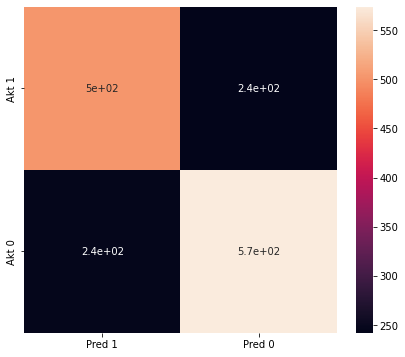

In [428]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_svm_tuning,annot=True)

## Naive Bayes

In [429]:
NB_Tuned = GaussianNB()

In [430]:
param_NB = {
    'var_smoothing' : np.logspace(0, -9, num=10000)
}

In [431]:
GS_NB = GridSearchCV(GaussianNB(), param_NB, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [432]:
GS_NB.fit(X_train_sc, y_train)

Fitting 4 folds for each of 10000 candidates, totalling 40000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 9.97929612e-01, 9.95863511e-01, ...,
       1.00415367e-09, 1.00207468e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [433]:
NB_Tuned = GS_NB.best_estimator_

In [434]:
NB_tu_Acc_train, NB_tu_Rec_train, NB_tu_Prec_train, NB_tu_F1_train = Eva_Matrix(NB_Tuned, X_train_sc, y_train)

In [435]:
NB_tu_Acc_test, NB_tu_Rec_test, NB_tu_Prec_test, NB_tu_F1_test = Eva_Matrix(NB_Tuned, X_test_sc, y_test)

In [436]:
data_nb_tu = {
    "Naive Bayes Tuning Train" : [NB_tu_Acc_train, NB_tu_Rec_train, NB_tu_Prec_train, NB_tu_F1_train],
    "Naive Bayes Tuning Test" : [NB_tu_Acc_test, NB_tu_Rec_test, NB_tu_Prec_test, NB_tu_F1_test]
}

In [437]:
GNB3 = pd.DataFrame(data=data_nb_tu, index = ['Accuracy','Recall','Precision','F1'])
GNB3

,Naive Bayes Tuning Train,Naive Bayes Tuning Test
Accuracy,0.648320,0.686500
Recall,0.618425,0.642570
Precision,0.635456,0.682788
F1,0.626825,0.662069


In [438]:
GNB2

,Naive Bayes SC Train,Naive Bayes SC Test
Accuracy,0.648480,0.671785
Recall,0.532998,0.566265
Precision,0.664578,0.691176
F1,0.591560,0.622517


In [439]:
GNB1

,Naive Bayes Train,Naive Bayes Test
Accuracy,0.648640,0.678183
Recall,0.568509,0.589023
Precision,0.651440,0.691824
F1,0.607156,0.636298


In [440]:
y_train_gnb_tuning = GS_NB.predict(X_train_sc)

In [441]:
print(classification_report(y_train_gnb_tuning, y_train))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67      3345
           1       0.62      0.64      0.63      2905

    accuracy                           0.65      6250
   macro avg       0.65      0.65      0.65      6250
weighted avg       0.65      0.65      0.65      6250



In [442]:
cm_train_gnb_tuning = confusion_matrix(y_train_gnb_tuning, y_train, labels=[1, 0])

In [443]:
df_cm_train_gnb_tuning = pd.DataFrame(data=cm_train_gnb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_gnb_tuning

,Pred 1,Pred 0
Akt 1,1846,1059
Akt 0,1139,2206


<AxesSubplot:>

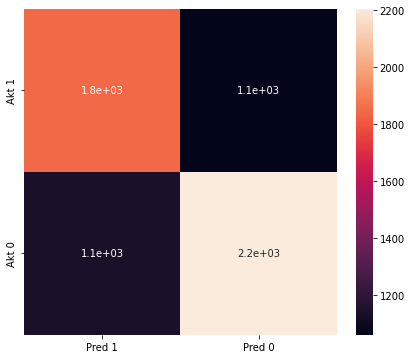

In [444]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_gnb_tuning,annot=True)

In [445]:
y_test_gnb_tuning = GS_NB.predict(X_test_sc)

In [446]:
print(classification_report(y_test_gnb_tuning, y_test))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       860
           1       0.64      0.68      0.66       703

    accuracy                           0.69      1563
   macro avg       0.68      0.69      0.68      1563
weighted avg       0.69      0.69      0.69      1563



In [447]:
cm_test_gnb_tuning = confusion_matrix(y_test_gnb_tuning, y_test, labels=[1, 0])

In [448]:
df_cm_test_gnb_tuning = pd.DataFrame(data=cm_test_gnb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_gnb_tuning

,Pred 1,Pred 0
Akt 1,480,223
Akt 0,267,593


<AxesSubplot:>

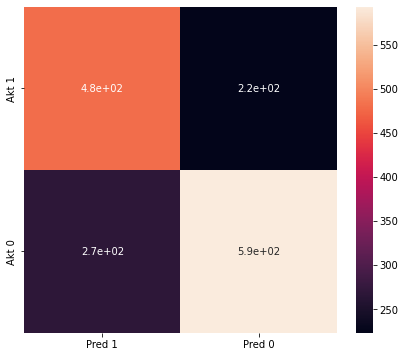

In [449]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_gnb_tuning,annot=True)

## Decision Tree

In [450]:
DT_Tuned = DecisionTreeClassifier()

In [451]:
param_DT = {
    "class_weight" : [{0 : .4, 1 : .6}, {0 : .6, 1: 4}, "balanced", {0: .3, 1: 7}],
    "splitter" : ['best','random'],   
    'min_samples_leaf' : np.arange(1,65,1),
    'max_depth' : np.arange(1,45,1)
}

In [452]:
GS_DT = GridSearchCV(DecisionTreeClassifier(), param_DT, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [453]:
GS_DT.fit(X_train_sc, y_train)

Fitting 4 folds for each of 22528 candidates, totalling 90112 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.4, 1: 0.6}, {0: 0.6, 1: 4},
                                          'balanced', {0: 0.3, 1: 7}],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [454]:
DT_Tuned = GS_DT.best_estimator_

In [455]:
DT_tu_Acc_train, DT_tu_Rec_train, DT_tu_Prec_train, DT_tu_F1_train = Eva_Matrix(DT_Tuned, X_train_sc, y_train)

In [456]:
DT_tu_Acc_test, DT_tu_Rec_test, DT_tu_Prec_test, DT_tu_F1_test = Eva_Matrix(DT_Tuned, X_test_sc, y_test)

In [457]:
data_dt_tu = {
    "Decision Tree Tuning Train" : [DT_tu_Acc_train, DT_tu_Rec_train, DT_tu_Prec_train, DT_tu_F1_train],
    "Decision Tree Tuning Test" : [DT_tu_Acc_test, DT_tu_Rec_test, DT_tu_Prec_test, DT_tu_F1_test]
}

In [458]:
DT3 = pd.DataFrame(data=data_dt_tu, index = ['Accuracy','Recall','Precision','F1'])
DT3

,Decision Tree Tuning Train,Decision Tree Tuning Test
Accuracy,0.695840,0.686500
Recall,0.586600,0.580991
Precision,0.724152,0.710311
F1,0.648158,0.639175


In [459]:
DT2

,Decision Tree SC Train,Decision Tree SC Test
Accuracy,0.999680,0.615483
Recall,0.999330,0.619813
Precision,1.000000,0.593590
F1,0.999665,0.606418


In [460]:
DT1

,Decision Tree Train,Decision Tree Test
Accuracy,0.999680,0.618042
Recall,0.999330,0.603748
Precision,1.000000,0.599734
F1,0.999665,0.601734


In [461]:
y_train_dt_tuning = GS_DT.predict(X_train_sc)

In [462]:
print(classification_report(y_train_dt_tuning, y_train))

              precision    recall  f1-score   support

           0       0.80      0.68      0.73      3832
           1       0.59      0.72      0.65      2418

    accuracy                           0.70      6250
   macro avg       0.69      0.70      0.69      6250
weighted avg       0.71      0.70      0.70      6250



In [463]:
cm_train_dt_tuning = confusion_matrix(y_train_dt_tuning, y_train, labels=[1, 0])

In [464]:
df_cm_train_dt_tuning = pd.DataFrame(data=cm_train_dt_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_dt_tuning

,Pred 1,Pred 0
Akt 1,1751,667
Akt 0,1234,2598


<AxesSubplot:>

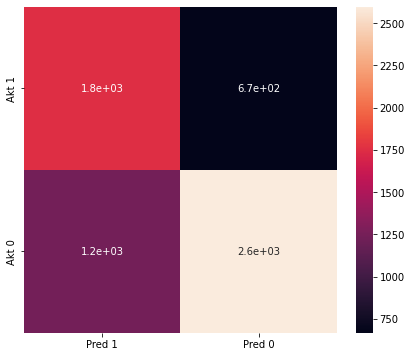

In [465]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_dt_tuning,annot=True)

In [466]:
y_test_dt_tuning = GS_DT.predict(X_test_sc)

In [467]:
print(classification_report(y_test_dt_tuning, y_test))

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       952
           1       0.58      0.71      0.64       611

    accuracy                           0.69      1563
   macro avg       0.68      0.69      0.68      1563
weighted avg       0.70      0.69      0.69      1563



In [468]:
cm_test_dt_tuning = confusion_matrix(y_test_dt_tuning, y_test, labels=[1, 0])

In [469]:
df_cm_test_dt_tuning = pd.DataFrame(data=cm_test_dt_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_dt_tuning

,Pred 1,Pred 0
Akt 1,434,177
Akt 0,313,639


<AxesSubplot:>

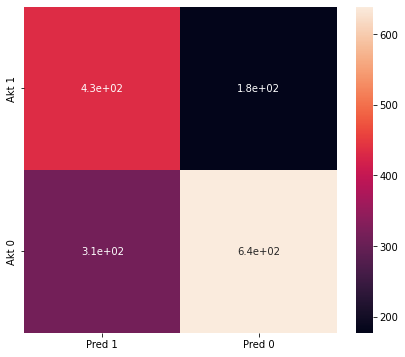

In [470]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_dt_tuning,annot=True)

## Random Forest

In [471]:
RF_Tuned = RandomForestClassifier()

In [472]:
param_RF = {
    'n_estimators' : np.arange(1,160,2),
    'min_samples_split' : np.arange(1,150,3),
    'max_depth' : np.arange(1,10,2)
}

In [473]:
GS_RF = GridSearchCV(RandomForestClassifier(), param_RF, cv= 2, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [474]:
GS_RF.fit(X_train_sc, y_train)

Fitting 2 folds for each of 20000 candidates, totalling 40000 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([1, 3, 5, 7, 9]),
                         'min_samples_split': array([  1,   4,   7,  10,  13,  16,  19,  22,  25,  28,  31,  34,  37,
        40,  43,  46,  49,  52,  55,  58,  61,  64,  67,  70,  73,  76,
        79,  82,  85,  88,  91,  94,  97, 100, 103, 106, 109, 112, 115,
       118, 121, 124, 127, 130, 133, 136, 139, 142, 145, 148]),
                         'n_estimators': array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155,
       157, 159])},
             scoring='accuracy', verbose=1)

In [475]:
RF_Tuned = GS_RF.best_estimator_

In [476]:
RF_tu_Acc_train, RF_tu_Rec_train, RF_tu_Prec_train, RF_tu_F1_train = Eva_Matrix(RF_Tuned, X_train_sc, y_train)

In [477]:
RF_tu_Acc_test, RF_tu_Rec_test, RF_tu_Prec_test, RF_tu_F1_test = Eva_Matrix(RF_Tuned, X_test_sc, y_test)

In [478]:
data_rf_tu = {
    "Random Forest Tuning Train" : [RF_tu_Acc_train, RF_tu_Rec_train, RF_tu_Prec_train, RF_tu_F1_train],
    "Random Forest Tuning Test" : [RF_tu_Acc_test, RF_tu_Rec_test, RF_tu_Prec_test, RF_tu_F1_test]
}

In [479]:
RF3 = pd.DataFrame(data=data_rf_tu, index = ['Accuracy','Recall','Precision','F1'])
RF3

,Random Forest Tuning Train,Random Forest Tuning Test
Accuracy,0.737920,0.721689
Recall,0.636516,0.630522
Precision,0.774562,0.747619
F1,0.698786,0.684096


In [480]:
RF2

,Random Forest SC Train,Random Forest SC Test
Accuracy,0.999680,0.688420
Recall,0.999330,0.666667
Precision,1.000000,0.676630
F1,0.999665,0.671612


In [481]:
RF1

,Random Forest Train,Random Forest Test
Accuracy,0.999520,0.694818
Recall,0.999330,0.631861
Precision,0.999665,0.700297
F1,0.999497,0.664321


In [482]:
y_train_rf_tuning = GS_RF.predict(X_train_sc)

In [483]:
print(classification_report(y_train_rf_tuning, y_train))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      3797
           1       0.64      0.77      0.70      2453

    accuracy                           0.74      6250
   macro avg       0.73      0.74      0.73      6250
weighted avg       0.75      0.74      0.74      6250



In [484]:
cm_train_rf_tuning = confusion_matrix(y_train_rf_tuning, y_train, labels=[1, 0])

In [485]:
df_cm_train_rf_tuning = pd.DataFrame(data=cm_train_rf_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_rf_tuning

,Pred 1,Pred 0
Akt 1,1900,553
Akt 0,1085,2712


<AxesSubplot:>

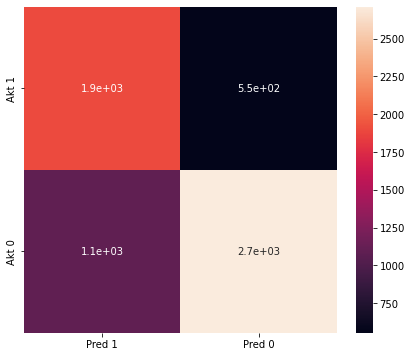

In [486]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_rf_tuning,annot=True)

In [487]:
y_test_rf_tuning = GS_RF.predict(X_test_sc)

In [488]:
print(classification_report(y_test_rf_tuning, y_test))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       933
           1       0.63      0.75      0.68       630

    accuracy                           0.72      1563
   macro avg       0.72      0.73      0.72      1563
weighted avg       0.73      0.72      0.72      1563



In [489]:
cm_test_rf_tuning = confusion_matrix(y_test_rf_tuning, y_test, labels=[1, 0])

In [490]:
df_cm_test_rf_tuning = pd.DataFrame(data=cm_test_rf_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_rf_tuning

,Pred 1,Pred 0
Akt 1,471,159
Akt 0,276,657


<AxesSubplot:>

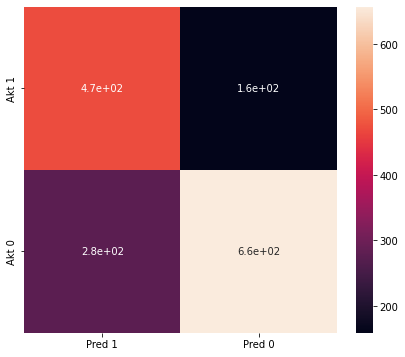

In [491]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_rf_tuning,annot=True)

## XGB Boost

In [492]:
XGB_Tuned = XGBClassifier()

In [493]:
param_XGB = {
    'n_estimators' : np.arange(1,185,1)
}

In [494]:
GS_XGB = GridSearchCV(XGBClassifier(), param_XGB, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [495]:
GS_XGB.fit(X_train_sc, y_train)

Fitting 4 folds for each of 184 candidates, totalling 736 fits
[21:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, mi...
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 1

In [496]:
XGB_Tuned = GS_XGB.best_estimator_

In [497]:
XGB_tu_Acc_train, XGB_tu_Rec_train, XGB_tu_Prec_train, XGB_tu_F1_train = Eva_Matrix(XGB_Tuned, X_train_sc, y_train)

In [498]:
XGB_tu_Acc_test, XGB_tu_Rec_test, XGB_tu_Prec_test, XGB_tu_F1_test = Eva_Matrix(XGB_Tuned, X_test_sc, y_test)

In [499]:
data_xgb_tu = {
    "XGB Tuning Train" : [XGB_tu_Acc_train, XGB_tu_Rec_train, XGB_tu_Prec_train, XGB_tu_F1_train],
    "XGB Tuning Test" : [XGB_tu_Acc_test, XGB_tu_Rec_test, XGB_tu_Prec_test, XGB_tu_F1_test]
}

In [500]:
XGB3 = pd.DataFrame(data=data_xgb_tu, index = ['Accuracy','Recall','Precision','F1'])
XGB3

,XGB Tuning Train,XGB Tuning Test
Accuracy,0.765280,0.717210
Recall,0.675377,0.619813
Precision,0.801909,0.745572
F1,0.733224,0.676901


In [501]:
XGB2

,XGB SC Train,XGB SC Test
Accuracy,0.881440,0.676264
Recall,0.821106,0.654618
Precision,0.922122,0.663501
F1,0.868687,0.659030


In [502]:
XGB1

,XGB Train,XGB Test
Accuracy,0.881440,0.692898
Recall,0.821106,0.619813
Precision,0.922122,0.702580
F1,0.868687,0.658606


In [503]:
y_train_xgb_tuning = GS_XGB.predict(X_train_sc)

In [504]:
print(classification_report(y_train_xgb_tuning, y_train))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      3736
           1       0.68      0.80      0.73      2514

    accuracy                           0.77      6250
   macro avg       0.76      0.77      0.76      6250
weighted avg       0.78      0.77      0.77      6250



In [505]:
cm_train_xgb_tuning = confusion_matrix(y_train_xgb_tuning, y_train, labels=[1, 0])

In [506]:
df_cm_train_xgb_tuning = pd.DataFrame(data=cm_train_xgb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_xgb_tuning

,Pred 1,Pred 0
Akt 1,2016,498
Akt 0,969,2767


<AxesSubplot:>

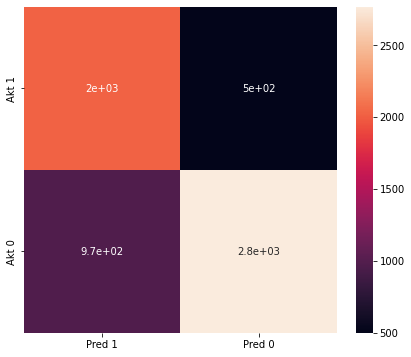

In [507]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_xgb_tuning,annot=True)

In [508]:
y_test_xgb_tuning = GS_XGB.predict(X_test_sc)

In [509]:
print(classification_report(y_test_xgb_tuning, y_test))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       942
           1       0.62      0.75      0.68       621

    accuracy                           0.72      1563
   macro avg       0.71      0.72      0.71      1563
weighted avg       0.73      0.72      0.72      1563



In [510]:
cm_test_xgb_tuning = confusion_matrix(y_test_xgb_tuning, y_test, labels=[1, 0])

In [511]:
df_cm_test_xgb_tuning = pd.DataFrame(data=cm_test_xgb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_xgb_tuning

,Pred 1,Pred 0
Akt 1,463,158
Akt 0,284,658


<AxesSubplot:>

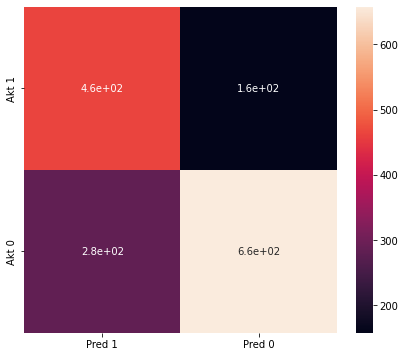

In [512]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_xgb_tuning,annot=True)

## Ada Boost

In [513]:
AB_Tuned = AdaBoostClassifier()

In [514]:
param_AB = {
    'n_estimators' : np.arange(1,500,1),
    'algorithm' : ['SAMME.R']
}

In [515]:
GS_AB = GridSearchCV(AdaBoostClassifier(), param_AB, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [516]:
GS_AB.fit(X_train_sc, y_train)

Fitting 4 folds for each of 499 candidates, totalling 1996 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME.R'],
                         'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  6...
       417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429,
       430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
       443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455,
       456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468,
       469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481,
       482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 

In [517]:
AB_Tuned = GS_AB.best_estimator_

In [518]:
AB_tu_Acc_train, AB_tu_Rec_train, AB_tu_Prec_train, AB_tu_F1_train = Eva_Matrix(AB_Tuned, X_train_sc, y_train)

In [519]:
AB_tu_Acc_test, AB_tu_Rec_test, AB_tu_Prec_test, AB_tu_F1_test = Eva_Matrix(AB_Tuned, X_test_sc, y_test)

In [520]:
data_ab_tu = {
    "Ada Boost Tuning Train" : [AB_tu_Acc_train, AB_tu_Rec_train, AB_tu_Prec_train, AB_tu_F1_train],
    "Ada Boost Tuning Test" : [AB_tu_Acc_test, AB_tu_Rec_test, AB_tu_Prec_test, AB_tu_F1_test]
}

In [521]:
AB3 = pd.DataFrame(data=data_ab_tu, index = ['Accuracy','Recall','Precision','F1'])
AB3

,Ada Boost Tuning Train,Ada Boost Tuning Test
Accuracy,0.701600,0.696097
Recall,0.629816,0.626506
Precision,0.712121,0.704819
F1,0.668444,0.663359


In [522]:
AB2

,Ada Boost SC Train,Ada Boost SC Test
Accuracy,0.701280,0.687140
Recall,0.624456,0.678715
Precision,0.714176,0.670635
F1,0.666309,0.674651


In [523]:
AB1

,Ada Boost Train,Ada Boost Test
Accuracy,0.701280,0.697377
Recall,0.624456,0.621151
Precision,0.714176,0.709480
F1,0.666309,0.662384


In [524]:
y_train_ab_tuning = GS_AB.predict(X_train_sc)

In [525]:
print(classification_report(y_train_ab_tuning, y_train))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      3610
           1       0.63      0.71      0.67      2640

    accuracy                           0.70      6250
   macro avg       0.70      0.70      0.70      6250
weighted avg       0.71      0.70      0.70      6250



In [526]:
cm_train_ab_tuning = confusion_matrix(y_train_ab_tuning, y_train, labels=[1, 0])

In [527]:
df_cm_train_ab_tuning = pd.DataFrame(data=cm_train_ab_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_ab_tuning

,Pred 1,Pred 0
Akt 1,1880,760
Akt 0,1105,2505


<AxesSubplot:>

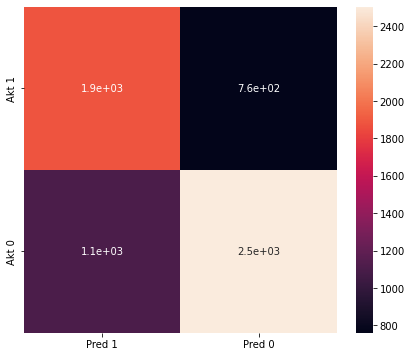

In [528]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_ab_tuning,annot=True)

In [529]:
y_test_ab_tuning = GS_AB.predict(X_test_sc)

In [530]:
print(classification_report(y_test_ab_tuning, y_test))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       899
           1       0.63      0.70      0.66       664

    accuracy                           0.70      1563
   macro avg       0.69      0.70      0.69      1563
weighted avg       0.70      0.70      0.70      1563



In [531]:
cm_test_ab_tuning = confusion_matrix(y_test_ab_tuning, y_test, labels=[1, 0])

In [532]:
df_cm_test_ab_tuning = pd.DataFrame(data=cm_test_ab_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_ab_tuning

,Pred 1,Pred 0
Akt 1,468,196
Akt 0,279,620


<AxesSubplot:>

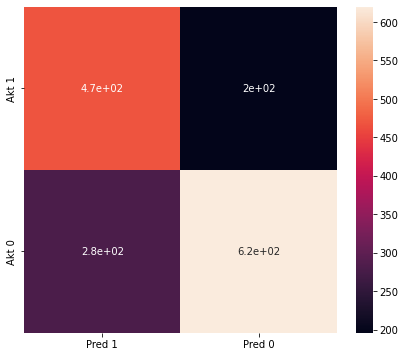

In [533]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_ab_tuning,annot=True)

## Gradient Boost

In [41]:
GB_Tuned = GradientBoostingClassifier()

In [42]:
param_GB = {
    'n_estimators' : np.arange(1,180,1),
    'max_depth' : np.arange(1,10,1),
    'max_features' : np.arange(1,10,1)
}

In [43]:
GS_GB = GridSearchCV(GradientBoostingClassifier(), param_GB, cv= 3, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [44]:
GS_GB.fit(X_train_sc, y_train)

Fitting 3 folds for each of 14499 candidates, totalling 43497 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,...
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164

In [45]:
GB_Tuned = GS_GB.best_estimator_

In [46]:
GB_tu_Acc_train, GB_tu_Rec_train, GB_tu_Prec_train, GB_tu_F1_train = Eva_Matrix(GB_Tuned, X_train_sc, y_train)

In [47]:
GB_tu_Acc_test, GB_tu_Rec_test, GB_tu_Prec_test, GB_tu_F1_test = Eva_Matrix(GB_Tuned, X_test_sc, y_test)

In [48]:
data_gb_tu = {
    "Gradient Boost Tuning Train" : [GB_tu_Acc_train, GB_tu_Rec_train, GB_tu_Prec_train, GB_tu_F1_train],
    "Gradient Boost Tuning Test" : [GB_tu_Acc_test, GB_tu_Rec_test, GB_tu_Prec_test, GB_tu_F1_test]
}

In [49]:
GB3 = pd.DataFrame(data=data_gb_tu, index = ['Accuracy','Recall','Precision','F1'])
GB3

,Gradient Boost Tuning Train,Gradient Boost Tuning Test
Accuracy,0.867840,0.709533
Recall,0.805695,0.617135
Precision,0.907205,0.732909
F1,0.853442,0.670058


In [51]:
y_train_gb_tuning = GS_GB.predict(X_train_sc)

In [52]:
print(classification_report(y_train_gb_tuning, y_train))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      3599
           1       0.81      0.91      0.85      2651

    accuracy                           0.87      6250
   macro avg       0.87      0.87      0.87      6250
weighted avg       0.87      0.87      0.87      6250



In [53]:
cm_train_gb_tuning = confusion_matrix(y_train_gb_tuning, y_train, labels=[1, 0])

In [54]:
df_cm_train_gb_tuning = pd.DataFrame(data=cm_train_gb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_gb_tuning

,Pred 1,Pred 0
Akt 1,2405,246
Akt 0,580,3019


<AxesSubplot:>

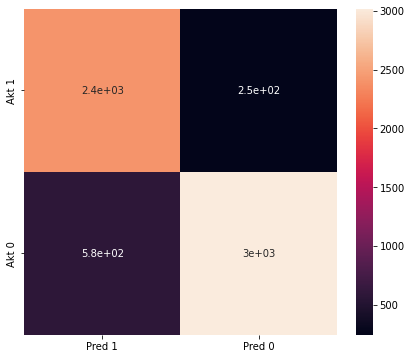

In [55]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_gb_tuning,annot=True)

In [56]:
y_test_gb_tuning = GS_GB.predict(X_test_sc)

In [57]:
print(classification_report(y_test_gb_tuning, y_test))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       934
           1       0.62      0.73      0.67       629

    accuracy                           0.71      1563
   macro avg       0.71      0.71      0.71      1563
weighted avg       0.72      0.71      0.71      1563



In [58]:
cm_test_gb_tuning = confusion_matrix(y_test_gb_tuning, y_test, labels=[1, 0])

In [59]:
df_cm_test_gb_tuning = pd.DataFrame(data=cm_test_gb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_gb_tuning

,Pred 1,Pred 0
Akt 1,461,168
Akt 0,286,648


<AxesSubplot:>

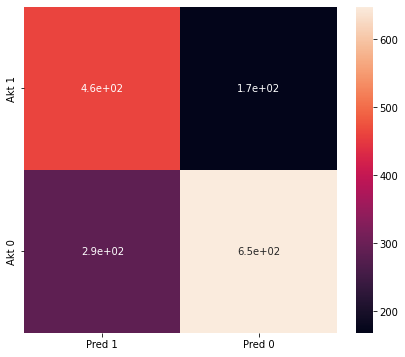

In [60]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_gb_tuning,annot=True)

## Cat Boost

In [61]:
CB_Tuned = CatBoostClassifier()

In [62]:
param_CB = {
    'n_estimators' : np.arange(1,185,1),
    'max_depth' : np.arange(1,80,1)
}

In [63]:
GS_CB = GridSearchCV(CatBoostClassifier(), param_CB, cv= skf, scoring= 'accuracy', n_jobs=-1, verbose=1)

In [64]:
GS_CB.fit(X_train_sc, y_train)

Fitting 4 folds for each of 14536 candidates, totalling 58144 fits
Learning rate set to 0.122351
0:	learn: 0.6698549	total: 161ms	remaining: 25.3s
1:	learn: 0.6505691	total: 167ms	remaining: 13s
2:	learn: 0.6366155	total: 172ms	remaining: 8.87s
3:	learn: 0.6241153	total: 176ms	remaining: 6.77s
4:	learn: 0.6145228	total: 180ms	remaining: 5.51s
5:	learn: 0.6073514	total: 185ms	remaining: 4.69s
6:	learn: 0.6000961	total: 191ms	remaining: 4.11s
7:	learn: 0.5946911	total: 195ms	remaining: 3.66s
8:	learn: 0.5893943	total: 199ms	remaining: 3.3s
9:	learn: 0.5859846	total: 204ms	remaining: 3.01s
10:	learn: 0.5817429	total: 208ms	remaining: 2.78s
11:	learn: 0.5792018	total: 212ms	remaining: 2.58s
12:	learn: 0.5768428	total: 217ms	remaining: 2.42s
13:	learn: 0.5747827	total: 221ms	remaining: 2.28s
14:	learn: 0.5726039	total: 228ms	remaining: 2.18s
15:	learn: 0.5714745	total: 233ms	remaining: 2.06s
16:	learn: 0.5687021	total: 238ms	remaining: 1.97s
17:	learn: 0.5667449	total: 242ms	remaining: 1.88

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=<catboost.core.CatBoostClassifier object at 0x0000018F87699910>,
             n_jobs=-1,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57,...
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184])},
             scoring='accuracy', verbose=1)

In [65]:
CB_Tuned = GS_CB.best_estimator_

In [66]:
CB_tu_Acc_train, CB_tu_Rec_train, CB_tu_Prec_train, CB_tu_F1_train = Eva_Matrix(CB_Tuned, X_train_sc, y_train)

In [67]:
CB_tu_Acc_test, CB_tu_Rec_test, CB_tu_Prec_test, CB_tu_F1_test = Eva_Matrix(CB_Tuned, X_test_sc, y_test)

In [68]:
data_cb_tu = {
    "Cat Boost Tuning Train" : [CB_tu_Acc_train, CB_tu_Rec_train, CB_tu_Prec_train, CB_tu_F1_train],
    "Cat Boost Tuning Test" : [CB_tu_Acc_test, CB_tu_Rec_test, CB_tu_Prec_test, CB_tu_F1_test]
}

In [69]:
CB3 = pd.DataFrame(data=data_cb_tu, index = ['Accuracy','Recall','Precision','F1'])
CB3

,Cat Boost Tuning Train,Cat Boost Tuning Test
Accuracy,0.790400,0.726807
Recall,0.709213,0.633199
Precision,0.827276,0.755591
F1,0.763709,0.689002


In [70]:
y_train_cb_tuning = GS_CB.predict(X_train_sc)

In [71]:
print(classification_report(y_train_cb_tuning, y_train))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      3691
           1       0.71      0.83      0.76      2559

    accuracy                           0.79      6250
   macro avg       0.79      0.80      0.79      6250
weighted avg       0.80      0.79      0.79      6250



In [72]:
cm_train_cb_tuning = confusion_matrix(y_train_cb_tuning, y_train, labels=[1, 0])

In [73]:
df_cm_train_cb_tuning = pd.DataFrame(data=cm_train_cb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_train_cb_tuning

,Pred 1,Pred 0
Akt 1,2117,442
Akt 0,868,2823


<AxesSubplot:>

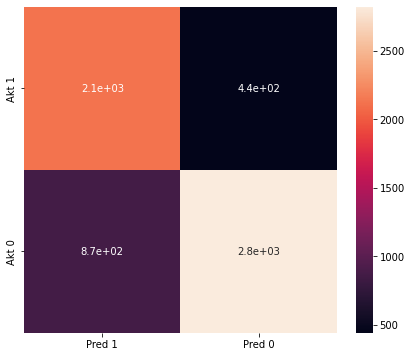

In [74]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_train_cb_tuning,annot=True)

In [75]:
y_test_cb_tuning = GS_CB.predict(X_test_sc)

In [76]:
print(classification_report(y_test_cb_tuning, y_test))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       937
           1       0.63      0.76      0.69       626

    accuracy                           0.73      1563
   macro avg       0.72      0.73      0.72      1563
weighted avg       0.74      0.73      0.73      1563



In [77]:
cm_test_cb_tuning = confusion_matrix(y_test_cb_tuning, y_test, labels=[1, 0])

In [78]:
df_cm_test_cb_tuning = pd.DataFrame(data=cm_test_cb_tuning, columns=['Pred 1','Pred 0'], index=['Akt 1','Akt 0'])
df_cm_test_cb_tuning

,Pred 1,Pred 0
Akt 1,473,153
Akt 0,274,663


<AxesSubplot:>

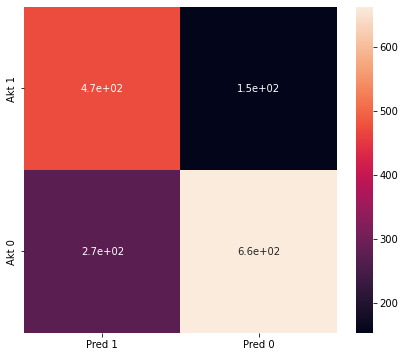

In [79]:
plt.figure(figsize=(7,6))
sns.heatmap(df_cm_test_cb_tuning,annot=True)

## Simulation

## Rata-rata call center 4 menit https://financesonline.com/call-center-statistics/; Minimal Deposito Rp 10 juta https://finansial.bisnis.com/read/20190729/55/1129828/mau-nabung-rasa-investasi-cek-bunga-deposito-di-8-bank-besar-ini

### Gradient Boosting: Customer plan deposito 168 * 4 = 672 menit 
### Income: 168 * 10.000.000 = Rp 1.680.000.000
### Customer predict not deposito 
### Loss: 286 * 10.000.000 = Rp 2.860.000.000

## ==========================================================

### Random Forest: Customer plan deposito 159 * 4 = 636 menit 
### Income: 159 * 10.000.000 = Rp 1.590.000.000
### Customer predict not deposito 
### Loss: 276 * 10.000.000 = Rp 2.760.000.000

## ==========================================================

### XGB: Customer plan deposito 158 * 4 = 632 menit 
### Income: 158 * 10.000.000 = Rp 1.580.000.000
### Customer predict not deposito 
### Loss: 284 * 10.000.000 = Rp 2.840.000.000

## ==========================================================

### Cat Boost: Customer plan deposito 153 * 4 = 612 menit 
### Income: 153 * 10.000.000 = Rp 1.530.000.000
### Customer predict not deposito 
### Loss: 274 * 10.000.000 = Rp 2.740.000.000